## Exploring Rat Dataset

Notebook for exploring rat dataset, writing import functions etc.

February 2023


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import platform
import statsmodels.api as sm

sns.set_context("talk")

MODE = "local"

In [2]:
if platform.system() == "Windows":
    DATA_PATH = pathlib.Path("X:\jbreda\learning_project\data")
else:
    if MODE == "cup":
        DATA_PATH = pathlib.Path("/Volumes/brody/jbreda/learning_project/data")
    elif MODE == "local":
        DATA_PATH = pathlib.Path("/Users/jessbreda/Desktop/github/animal-learning/data")
F_NAME = "rat_behavior.csv"
ANIMAL_ID = "W080"

#### Load CSV -> DF


In [3]:
DATA_PATH / F_NAME

PosixPath('/Users/jessbreda/Desktop/github/animal-learning/data/rat_behavior.csv')

In [4]:
RAT_DF = pd.read_csv(DATA_PATH / F_NAME)

In [5]:
RAT_DF["violation"] = RAT_DF.hit.isnull()
RAT_DF.subject_id = RAT_DF.subject_id.astype("string")
RAT_DF["n_trial"] = RAT_DF.index
RAT_DF["training_stage_cat"] = RAT_DF["training_stage"].astype("category")
RAT_DF["delay"] = RAT_DF.delay.round(2)

RAT_DF.head()

subject_id  session  trial  s_a  s_b  choice  correct_side  hit  delay   
0       W051        1      1  NaN  NaN     1.0             0  0.0   1.00  \
1       W051        2      1  NaN  NaN     1.0             0  0.0   0.01   
2       W051        2      2  NaN  NaN     0.0             0  1.0   0.01   
3       W051        2      3  NaN  NaN     0.0             1  0.0   0.01   
4       W051        2      4  NaN  NaN     1.0             0  0.0   0.01   

   training_stage  violation  n_trial training_stage_cat  
0               1      False        0                  1  
1               1      False        1                  1  
2               1      False        2                  1  
3               1      False        3                  1  
4               1      False        4                  1

In [6]:
W080_df = RAT_DF.query("subject_id == @ANIMAL_ID").reset_index(drop=True)

In [7]:
W080_df.head()

subject_id  session  trial  s_a  s_b  choice  correct_side  hit  delay   
0       W080        1      1  NaN  NaN     0.0             0  1.0   0.01  \
1       W080        1      2  NaN  NaN     1.0             0  0.0   0.01   
2       W080        1      3  NaN  NaN     1.0             0  0.0   0.01   
3       W080        1      4  NaN  NaN     0.0             0  1.0   0.01   
4       W080        1      5  NaN  NaN     0.0             1  0.0   0.01   

   training_stage  violation  n_trial training_stage_cat  
0               1      False  1617851                  1  
1               1      False  1617852                  1  
2               1      False  1617853                  1  
3               1      False  1617854                  1  
4               1      False  1617855                  1

In [8]:
W080_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97696 entries, 0 to 97695
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   subject_id          97696 non-null  string  
 1   session             97696 non-null  int64   
 2   trial               97696 non-null  int64   
 3   s_a                 89491 non-null  float64 
 4   s_b                 89491 non-null  float64 
 5   choice              78540 non-null  float64 
 6   correct_side        97696 non-null  int64   
 7   hit                 78540 non-null  float64 
 8   delay               97696 non-null  float64 
 9   training_stage      97696 non-null  int64   
 10  violation           97696 non-null  bool    
 11  n_trial             97696 non-null  int64   
 12  training_stage_cat  97696 non-null  category
dtypes: bool(1), category(1), float64(5), int64(5), string(1)
memory usage: 8.4 MB


## Sessions & Stage


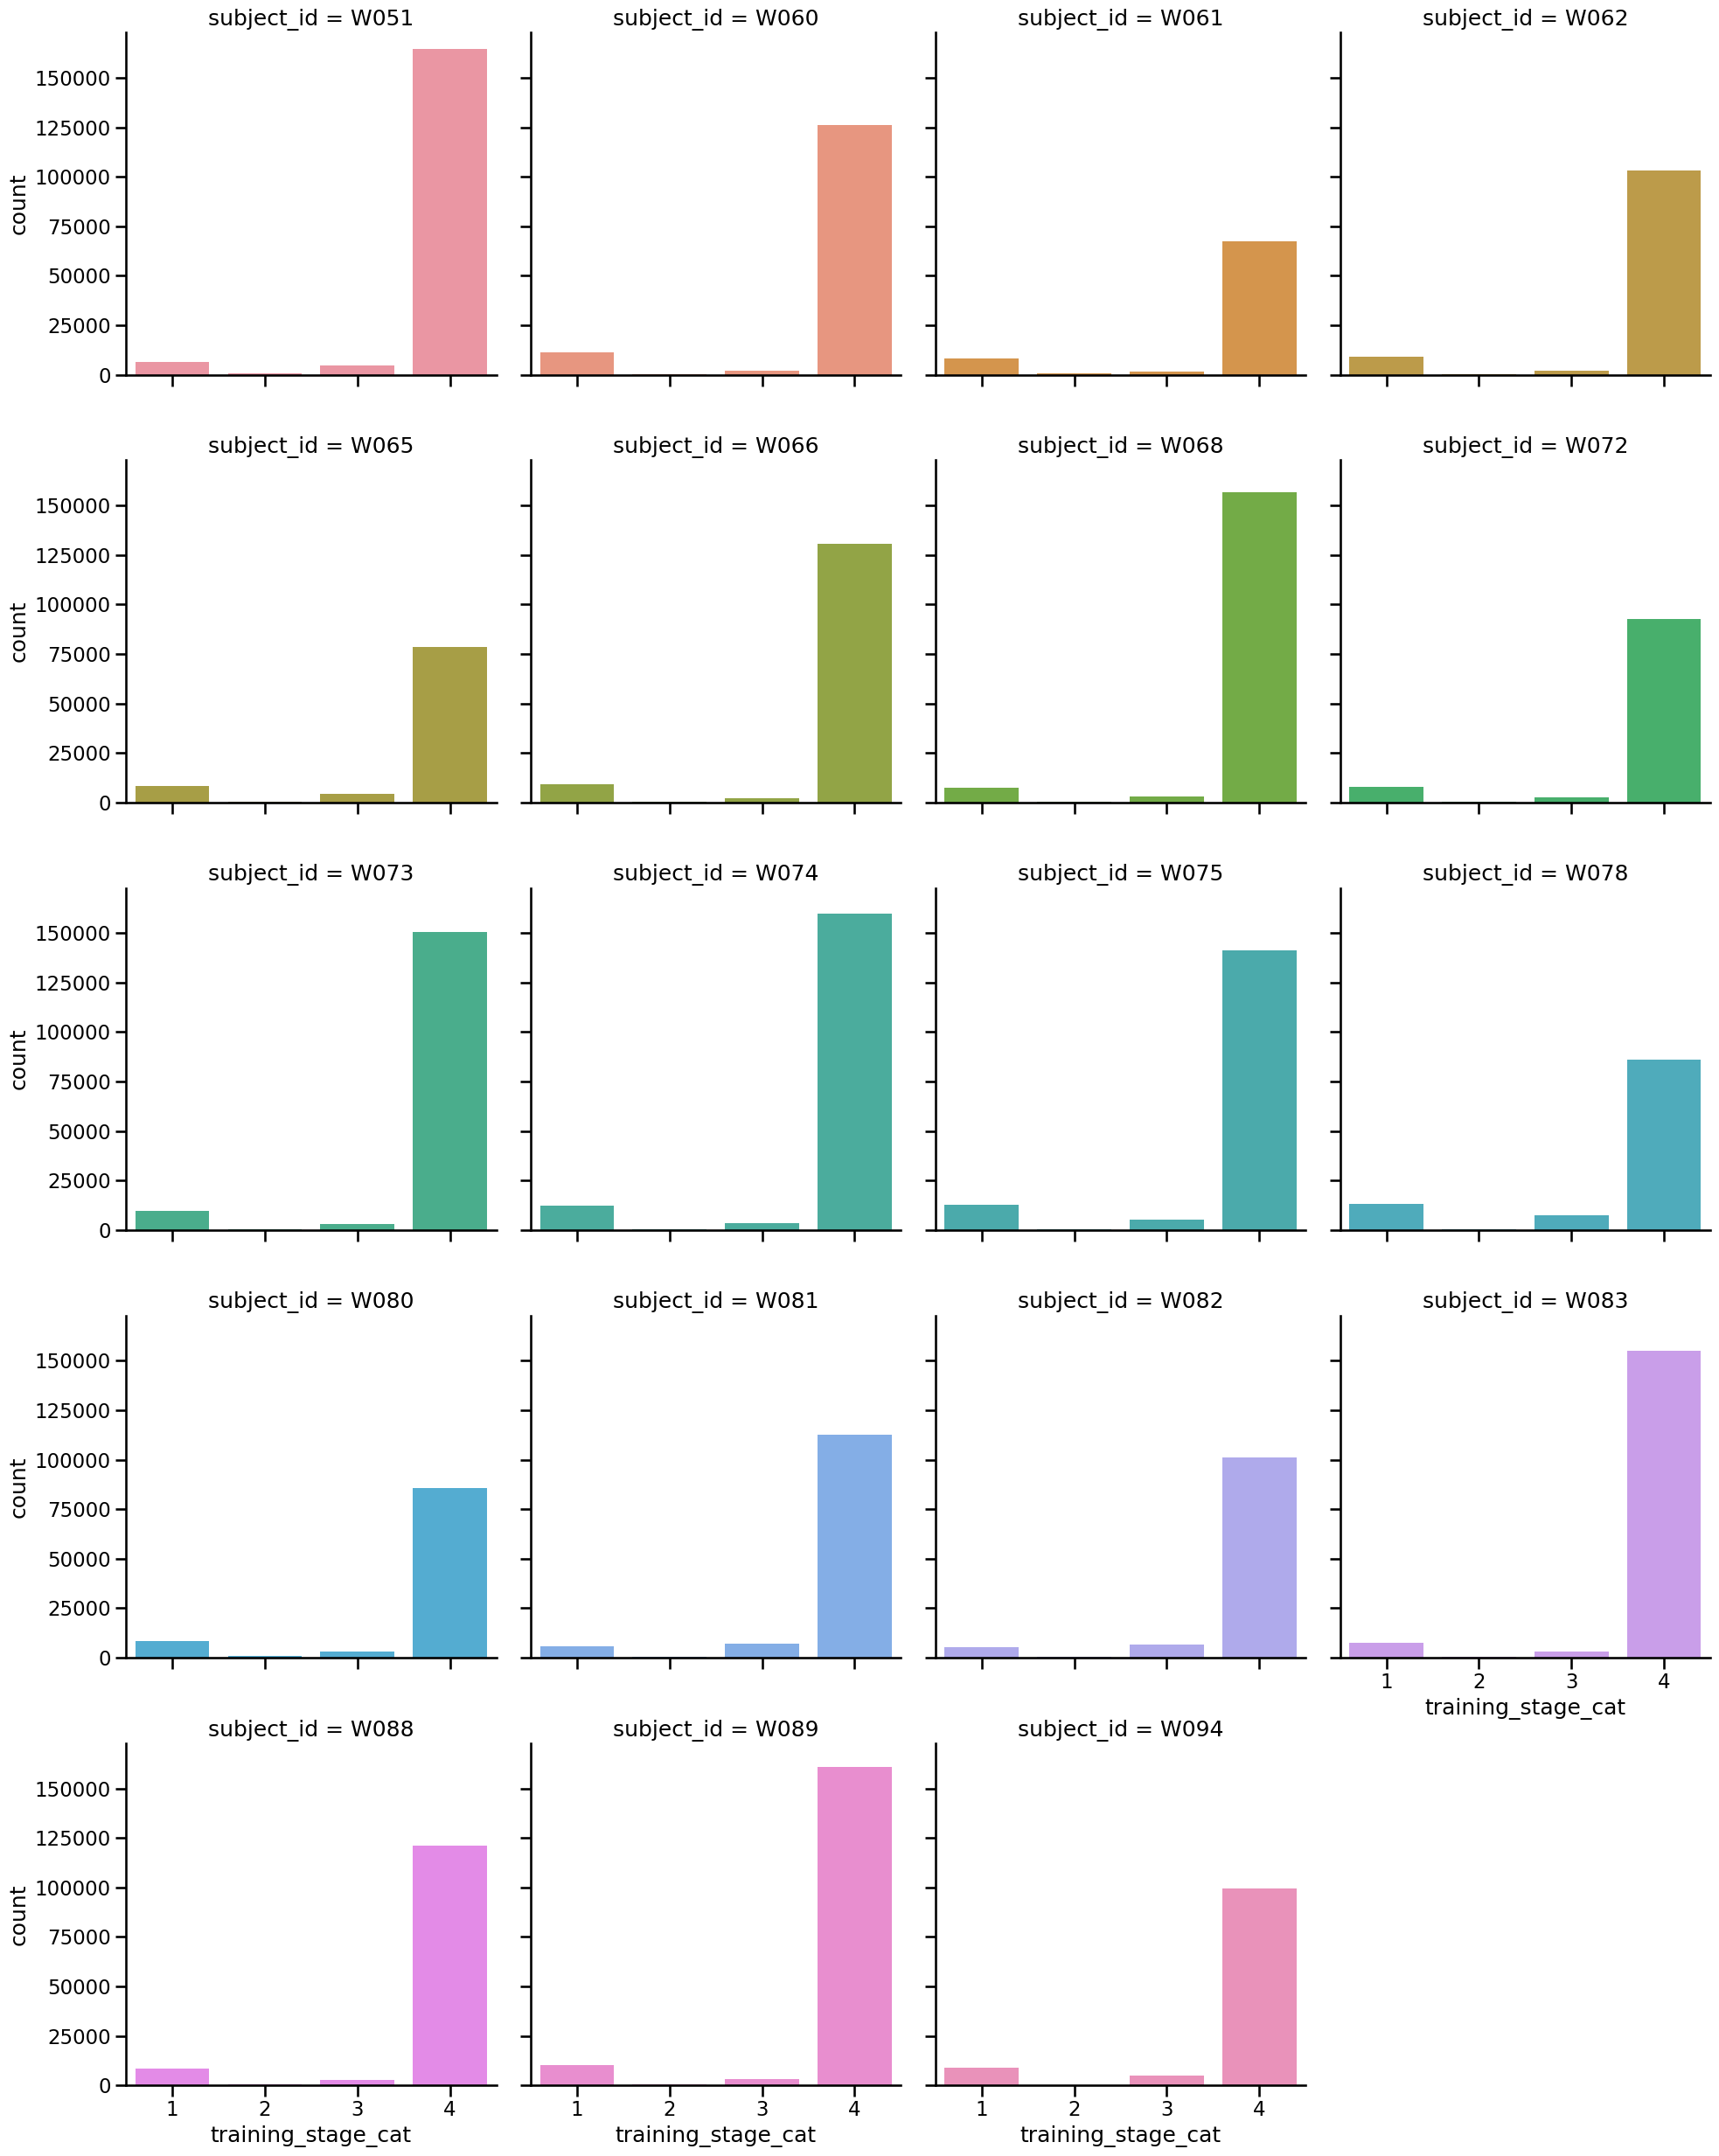

In [9]:
g = sns.catplot(
    x="training_stage_cat",
    col="subject_id",
    col_wrap=4,
    hue="subject_id",
    data=RAT_DF,
    kind="count",
    dodge=False,
    sharey=True,
)

Text(0.5, 1.0, 'N Trials per Session')

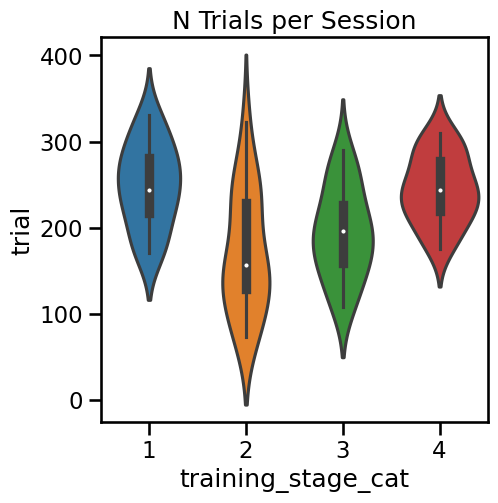

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
trials_per_session = (
    RAT_DF.groupby(["training_stage_cat", "subject_id", "session"])
    .trial.max()
    .reset_index()
    .groupby(["training_stage_cat", "subject_id"])
    .trial.mean()
    .reset_index()
)

sns.violinplot(data=trials_per_session, x="training_stage_cat", y="trial")

ax.set_title("N Trials per Session")

Text(0.5, 1.0, 'N trials per Session')

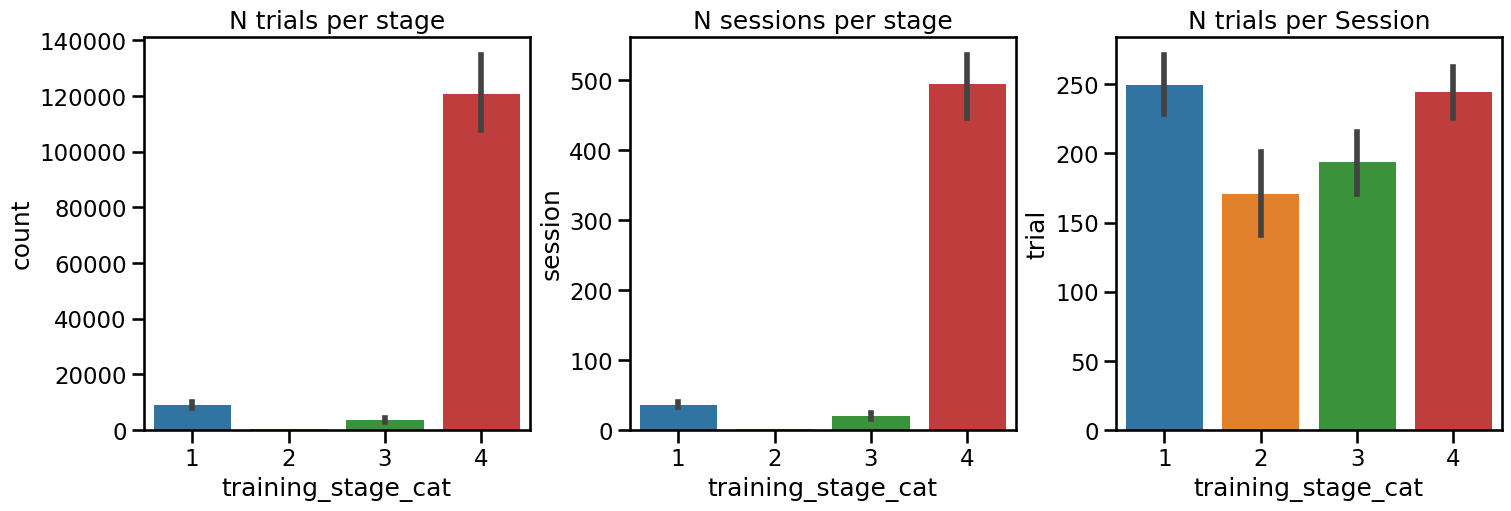

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

trial_counts = (
    RAT_DF.groupby(["training_stage_cat", "subject_id"])
    .size()
    .reset_index(name="count")
)

sns.barplot(trial_counts, x="training_stage_cat", y="count", ax=ax[0])
ax[0].set_title("N trials per stage")

session_counts = (
    RAT_DF.groupby(["subject_id", "training_stage_cat"])["session"]
    .nunique()
    .reset_index()
)

sns.barplot(data=session_counts, x="training_stage_cat", y="session", ax=ax[1])
ax[1].set_title("N sessions per stage")

sns.barplot(data=trials_per_session, x="training_stage_cat", y="trial", ax=ax[2])
ax[2].set_title("N trials per Session")

## Time to Traing (TTT)

### Determine "trained" metric

First idea: mean rolling window of session hit rate. Window size is 14 (tried 10 and 20) and this seemed to give a stable amount of crossings.


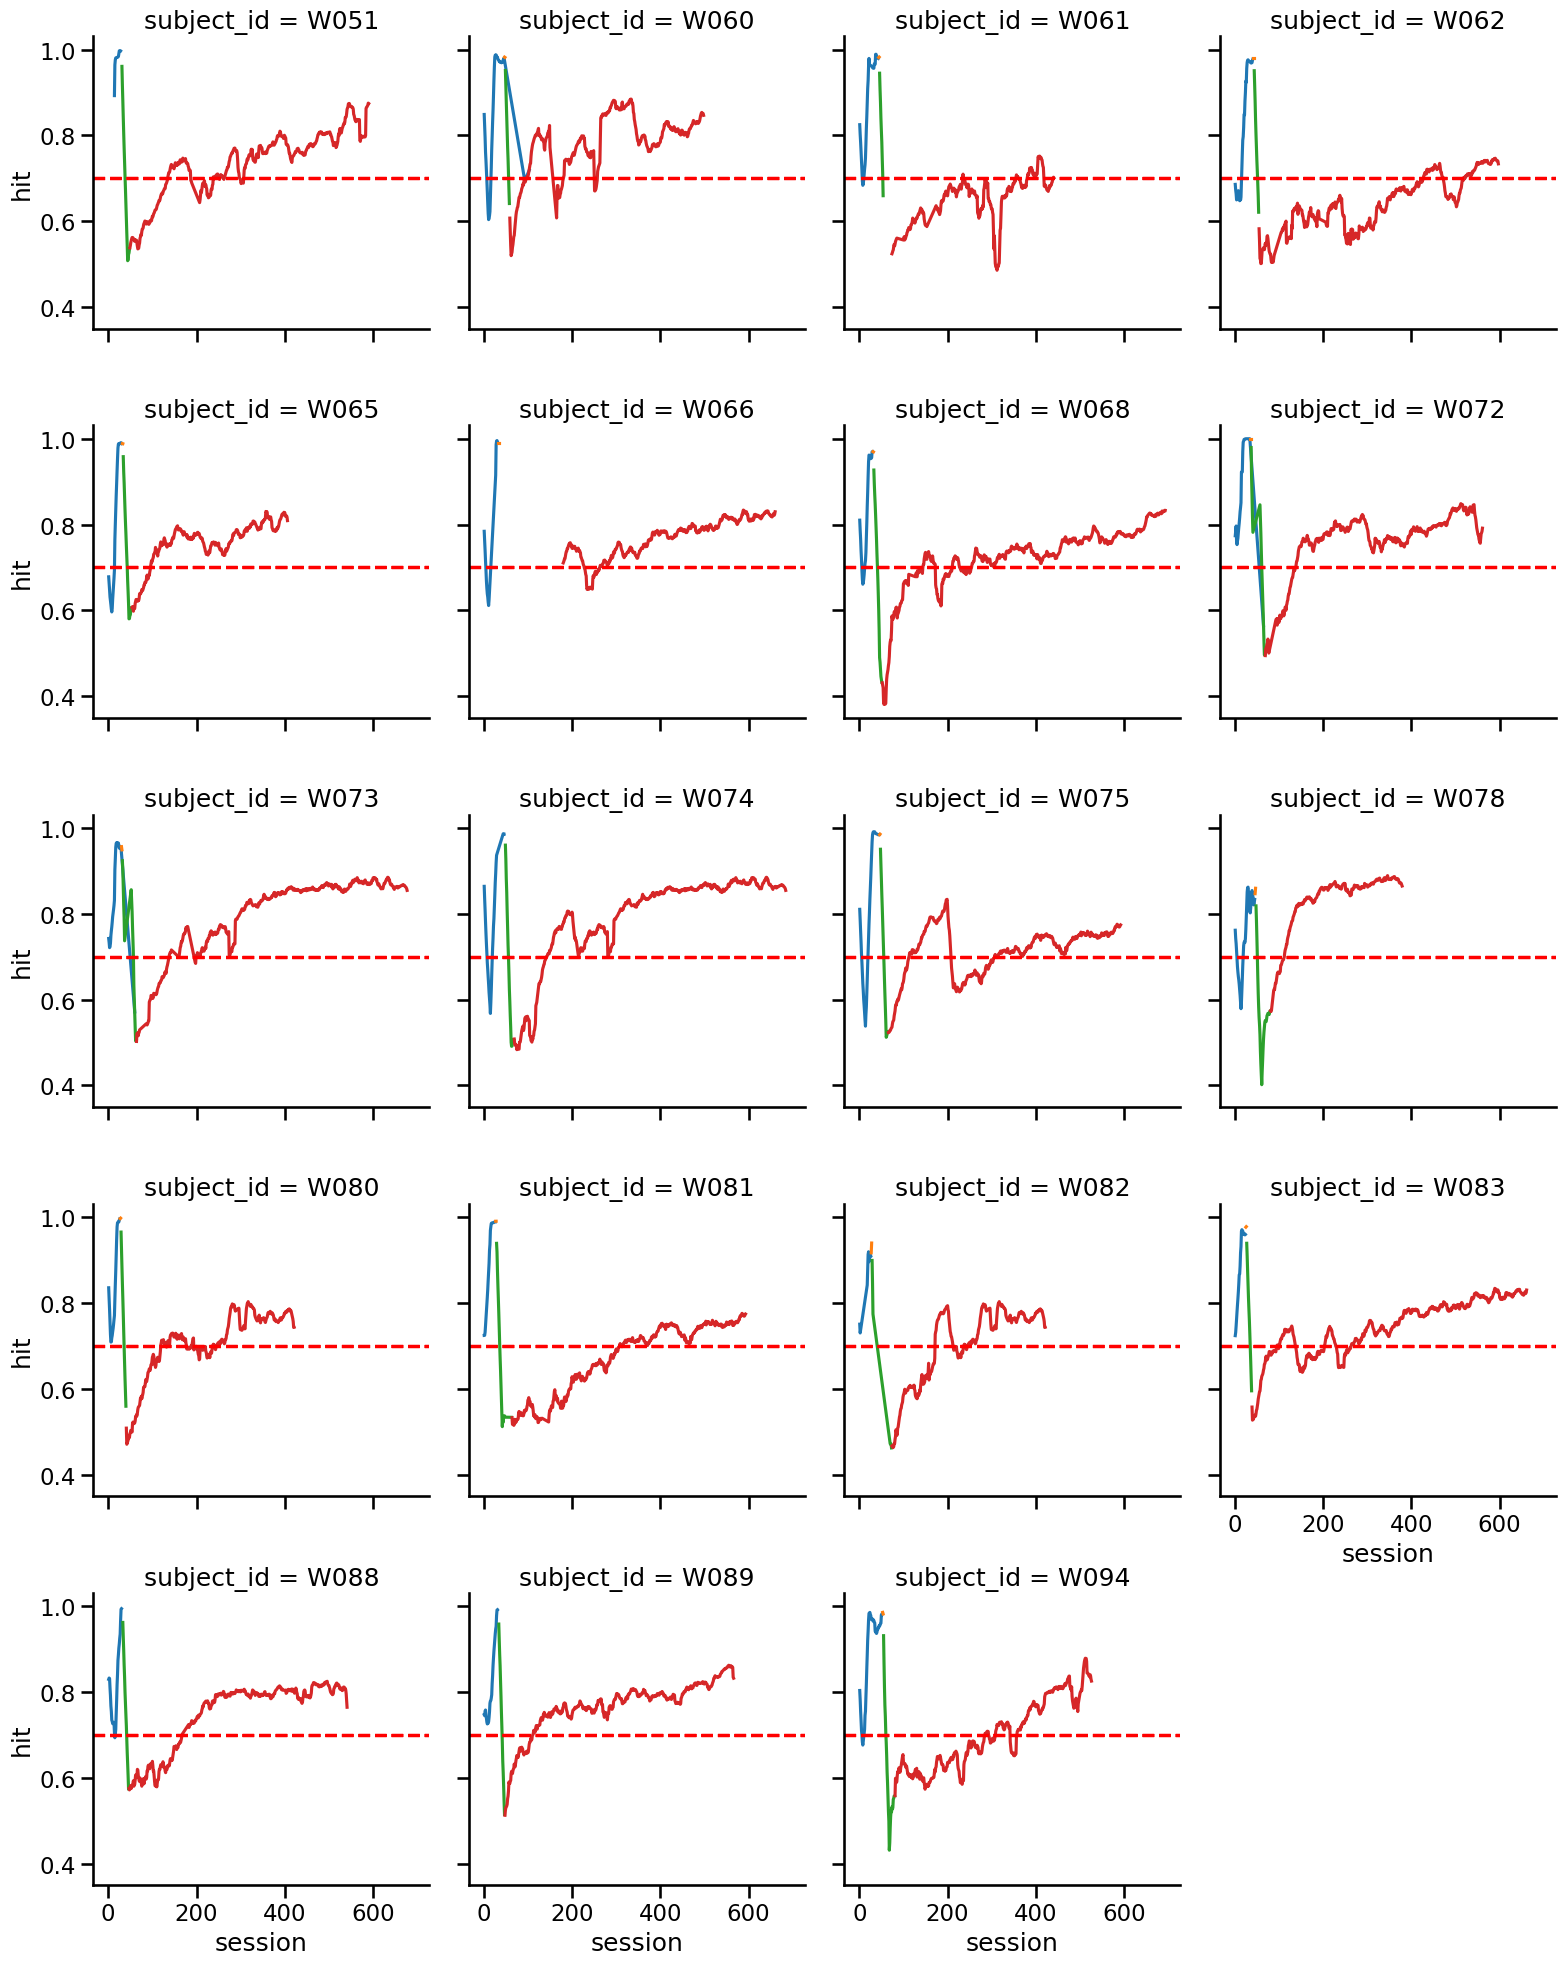

In [12]:
# Groupby subject and session, and calculate the mean hit for each subject-session combination
grouped_df = RAT_DF.groupby(["subject_id", "session", "training_stage"]).hit.mean()

# Calculate the rolling mean with a window of 14 sessions for each subject
rolling_mean = grouped_df.rolling(window=14).mean().reset_index()

# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean, col="subject_id", col_wrap=4, hue="training_stage", height=4
)
g.map(sns.lineplot, "session", "hit")
g.map(plt.axhline, y=0.7, color="red", linestyle="--")

Doing the same rolling windows, but only looking at stage 4


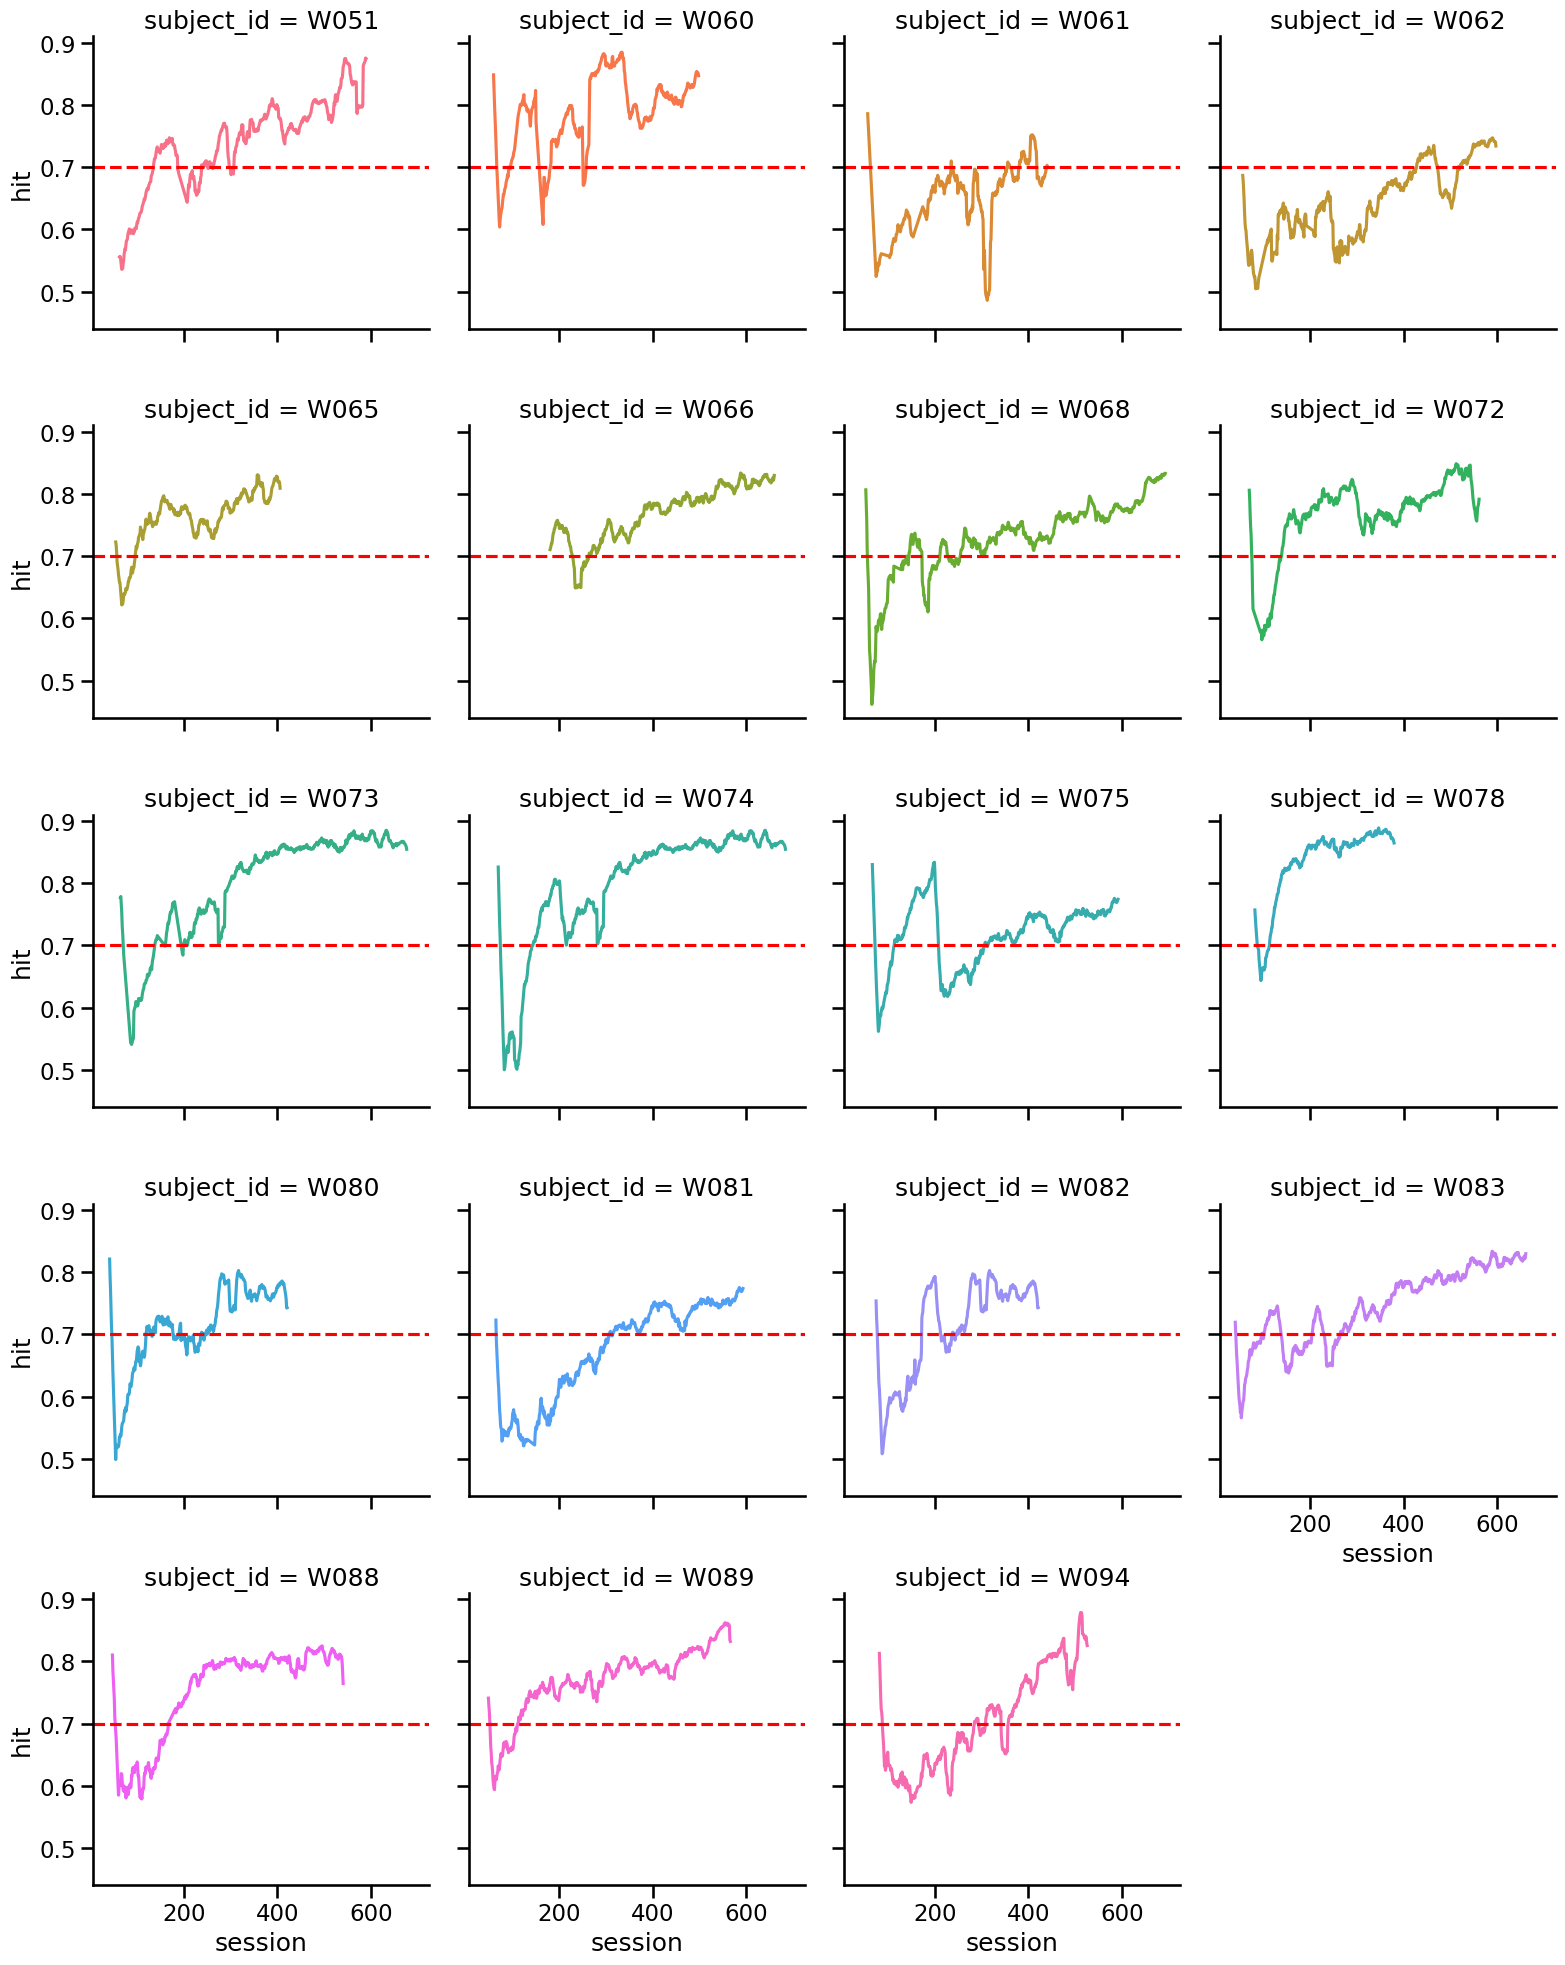

In [13]:
# Groupby subject and session, and calculate the mean hit for each subject-session combination
grouped_df = (
    RAT_DF.query("training_stage_cat == 4")
    .groupby(["subject_id", "session"])
    .hit.mean()
)

# Calculate the rolling mean with a window of 50 for each subject
rolling_mean = grouped_df.rolling(window=14).mean().reset_index()

# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean, col="subject_id", col_wrap=4, hue="subject_id", height=4
)
g.map(sns.lineplot, "session", "hit")
g.map(plt.axhline, y=0.70, color="red", linestyle="--")

Given a threshold (70%) over rolling window, determine how many crossings there are from low -> high across the threshold. Then for each animal in stage 4, calculate overall hit rate, number of crossings, the first session in which they crossed above the threshold, the last session and the median.


In [14]:
threshold = 0.70
rolling_mean["crossed_threshold"] = (rolling_mean["hit"].shift() < threshold) & (
    rolling_mean["hit"] >= threshold
)
crossings_count = rolling_mean.groupby("subject_id")["crossed_threshold"].sum()

In [15]:
train_threshold_df = pd.DataFrame({"subject_id": crossings_count.index})
train_threshold_df["avg_hit"] = (
    RAT_DF.query("training_stage_cat == 4").groupby("subject_id").hit.mean().values
)
train_threshold_df["n_crossings"] = crossings_count.values
train_threshold_df["min_cross_sess"] = (
    rolling_mean.groupby("subject_id")
    .apply(lambda x: x.loc[x["crossed_threshold"]].session.min())
    .values
)
train_threshold_df["med_cross_sess"] = (
    rolling_mean.groupby("subject_id")
    .apply(lambda x: x.loc[x["crossed_threshold"]].session.median())
    .values
)
train_threshold_df["max_cross_sess"] = (
    rolling_mean.groupby("subject_id")
    .apply(lambda x: x.loc[x["crossed_threshold"]].session.max())
    .values
)

train_threshold_df

subject_id   avg_hit  n_crossings  min_cross_sess  med_cross_sess   
0        W051  0.749555            6             135           247.0  \
1        W060  0.792743            4              92           138.5   
2        W061  0.649281            5             235           361.0   
3        W062  0.666781            3             428           517.0   
4        W065  0.763912            1              96            96.0   
5        W066  0.760298            1             263           263.0   
6        W068  0.755782            4             139           177.5   
7        W072  0.779687            1             138           138.0   
8        W073  0.817714            3             138           161.0   
9        W074  0.816161            1             144           144.0   
10       W075  0.724997            3             113           307.0   
11       W078  0.843409            1             113           113.0   
12       W080  0.723412            7             119           190.0   
13       W081  0.705802            2             308           311.5   
14       W082  0.723070            4             172           239.0   
15       W083  0.749971            4              96           152.5   
16       W088  0.778638            1             167           167.0   
17       W089  0.787937            1             111           111.0   
18       W094  0.743108            3             285           309.0   

    max_cross_sess  
0              307  
1              258  
2              439  
3              521  
4               96  
5              263  
6              255  
7              138  
8              200  
9              144  
10             314  
11             113  
12             246  
13             315  
14             246  
15             264  
16             167  
17             111  
18             357

### Validate chosen metric


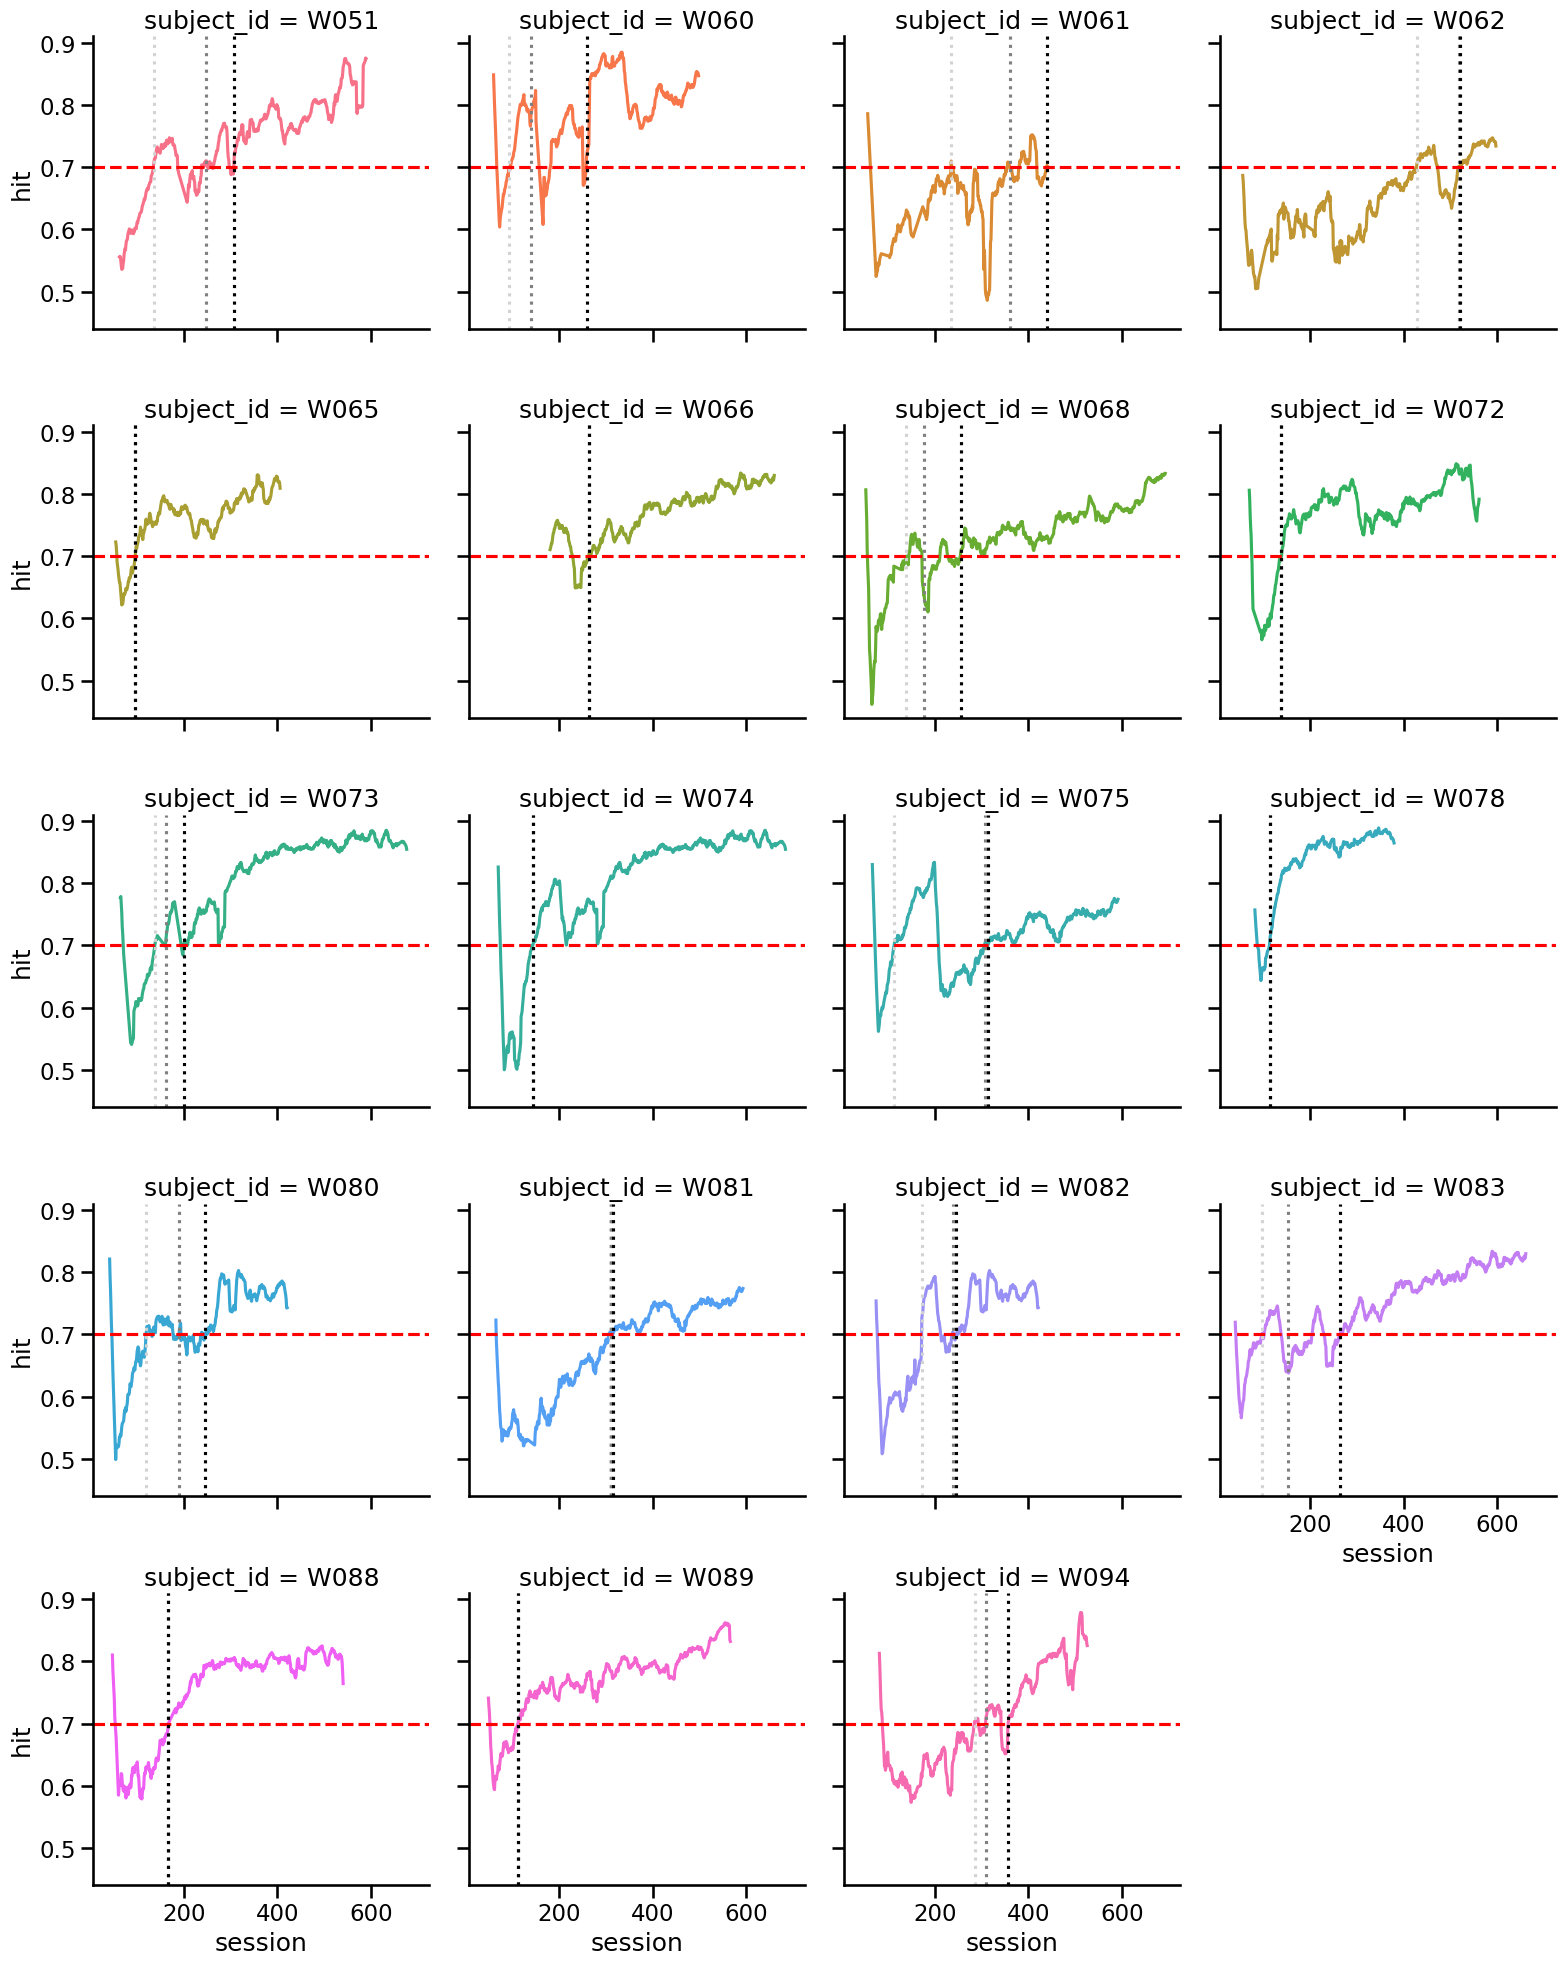

In [16]:
# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean, col="subject_id", col_wrap=4, hue="subject_id", height=4
)
g.map(sns.lineplot, "session", "hit")
g.map(plt.axhline, y=0.70, color="red", linestyle="--")

for ii, ax in enumerate(g.axes.flat):
    ax.axvline(
        x=train_threshold_df["min_cross_sess"][ii], color="lightgray", linestyle=":"
    )
    ax.axvline(x=train_threshold_df["med_cross_sess"][ii], color="gray", linestyle=":")
    ax.axvline(x=train_threshold_df["max_cross_sess"][ii], color="black", linestyle=":")

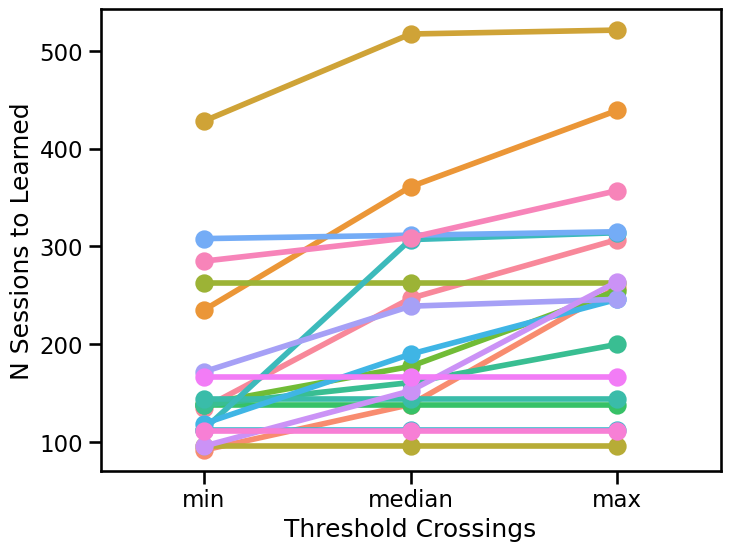

In [17]:
melted_df = train_threshold_df.melt(
    id_vars="subject_id",
    value_vars=["min_cross_sess", "med_cross_sess", "max_cross_sess"],
    var_name="threshold type",
    value_name="session",
)

# Create the catplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x="threshold type", y="session", hue="subject_id", data=melted_df, ax=ax)
ax.set_xticklabels(["min", "median", "max"])
ax.set(ylabel="N Sessions to Learned", xlabel="Threshold Crossings")
ax.legend_.remove()

#### TTT summary stats

Using the max crossing threshold animals take one average 250 sessions +/- 112. This variance is huge!


In [18]:
train_threshold_df["max_cross_sess"].describe()

count     19.000000
mean     250.210526
std      112.457685
min       96.000000
25%      155.500000
50%      255.000000
75%      310.500000
max      521.000000
Name: max_cross_sess, dtype: float64

[Text(0, 0.5, 'N Session Learn (max)')]

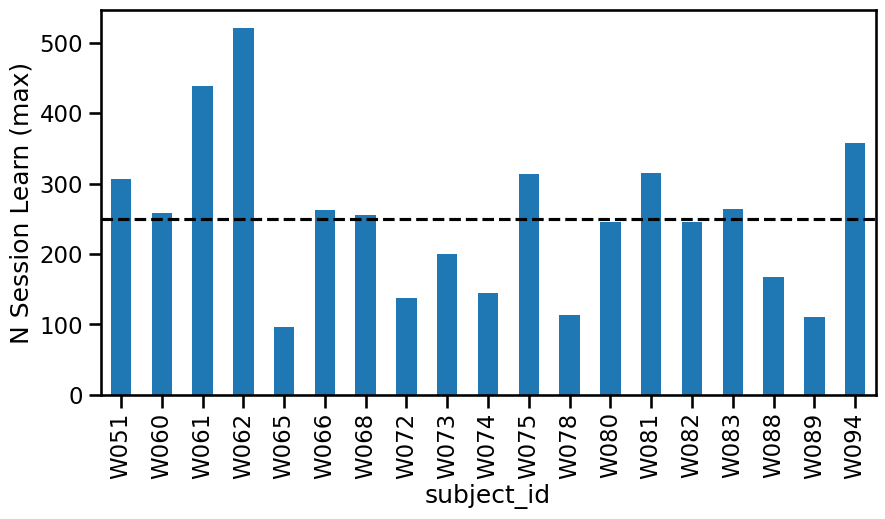

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
train_threshold_df.plot(
    kind="bar", x="subject_id", y="max_cross_sess", legend=False, ax=ax
)
ax.axhline(y=train_threshold_df["max_cross_sess"].mean(), color="k", linestyle="--")
ax.set(ylabel="N Session Learn (max)")

### TTT Relationships


There appears to be a slight positive correlation between number of crossings and ttt.


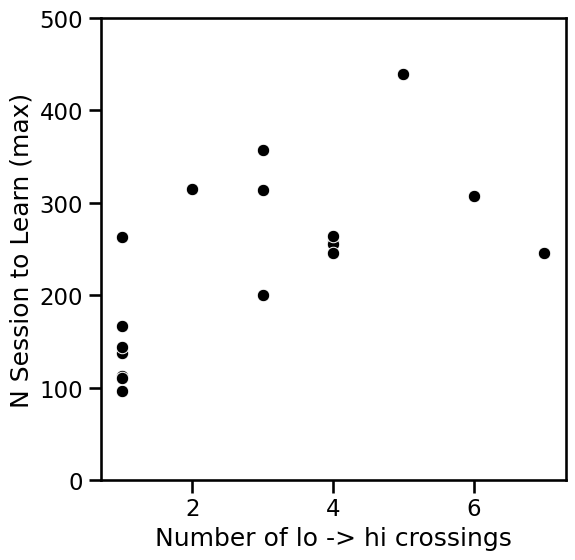

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=train_threshold_df, x="n_crossings", y="max_cross_sess", color="k", ax=ax
)

_ = ax.set(
    ylim=(0, 500),
    ylabel="N Session to Learn (max)",
    xlabel="Number of lo -> hi crossings",
)

There is a negative relationship between time to train and performance once trained. In other words, the faster an animal trains, the better their performance will be once they train.


In [21]:
# Get final performance
post_trained_DF = RAT_DF.merge(
    train_threshold_df[["subject_id", "max_cross_sess"]], on="subject_id"
)

post_trained_DF = post_trained_DF[
    post_trained_DF["session"] > post_trained_DF["max_cross_sess"]
]

# Drop the 'max_cross_sess' column from the filtered dataframe

train_threshold_df["post_train_hit"] = train_threshold_df["subject_id"].map(
    post_trained_DF.groupby("subject_id")["hit"].mean()
)

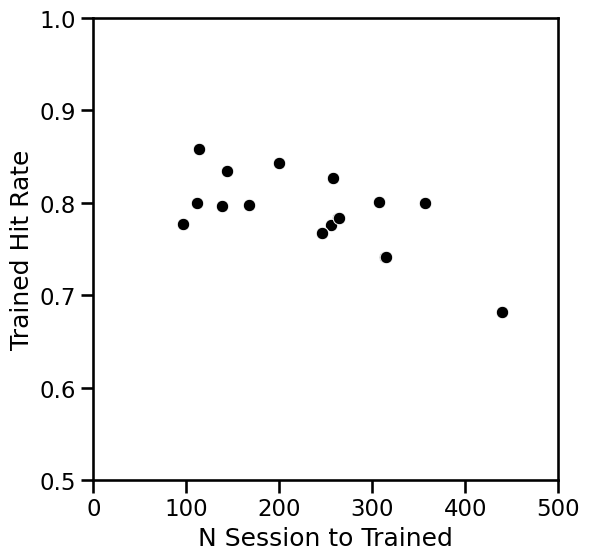

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=train_threshold_df, x="max_cross_sess", y="post_train_hit", color="k", ax=ax
)

_ = ax.set(
    ylim=(0.5, 1),
    xlim=(0, 500),
    xlabel="N Session to Trained",
    ylabel="Trained Hit Rate",
)

In [23]:
X = train_threshold_df["max_cross_sess"].values.reshape(-1, 1)
y = train_threshold_df["post_train_hit"].values.reshape(-1, 1)


# Add a constant term to the predictor variable
X = sm.add_constant(X)

# Create and fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     14.50
Date:                Tue, 06 Jun 2023   Prob (F-statistic):            0.00141
Time:                        10:35:40   Log-Likelihood:                 39.587
No. Observations:                  19   AIC:                            -75.17
Df Residuals:                      17   BIC:                            -73.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8483      0.018     46.536      0.0

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(400, 0.85, '$R^2$ = 0.429')

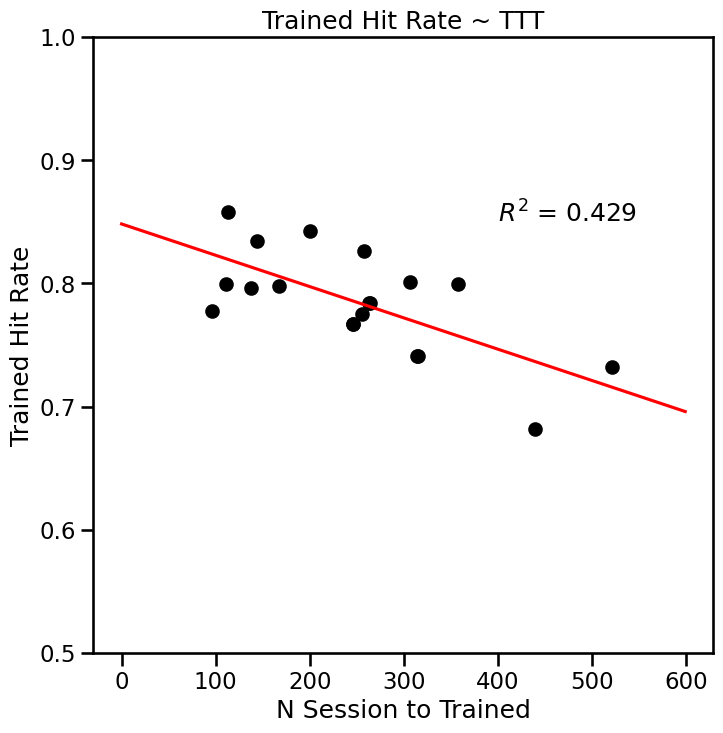

In [24]:
plt.figure(figsize=(8, 8))
slope = results.params[1]
intercept = results.params[0]

# Plot the data points
plt.scatter(
    train_threshold_df["max_cross_sess"],
    train_threshold_df["post_train_hit"],
    color="black",
    label="Data",
)

# # Plot the line model
x_line = np.arange(0, 600, 1)

# # Calculate the corresponding y-values based on the linear regression model
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color="red", label="Regression Line")

# Add labels and title
plt.ylabel("Trained Hit Rate")
plt.xlabel("N Session to Trained")
plt.ylim(0.5, 1)
plt.title("Trained Hit Rate ~ TTT")

# # Add legend

plt.text(400, 0.85, "$R^2$ = 0.429")

Looking at the relationships between violation rate (within all stages and across all stages) and time to train. Note violation rate is only calculated on the first 200 sessions. After that point, it stops being tracked in the dataset.


In [25]:
train_threshold_df[["viol_stage_2", "hit_stage_2"]] = train_threshold_df[
    "subject_id"
].apply(
    lambda x: RAT_DF.query("training_stage_cat == 2 and subject_id == @x")[
        ["violation", "hit"]
    ].mean()
)

In [26]:
train_threshold_df

subject_id   avg_hit  n_crossings  min_cross_sess  med_cross_sess   
0        W051  0.749555            6             135           247.0  \
1        W060  0.792743            4              92           138.5   
2        W061  0.649281            5             235           361.0   
3        W062  0.666781            3             428           517.0   
4        W065  0.763912            1              96            96.0   
5        W066  0.760298            1             263           263.0   
6        W068  0.755782            4             139           177.5   
7        W072  0.779687            1             138           138.0   
8        W073  0.817714            3             138           161.0   
9        W074  0.816161            1             144           144.0   
10       W075  0.724997            3             113           307.0   
11       W078  0.843409            1             113           113.0   
12       W080  0.723412            7             119           190.0   
13       W081  0.705802            2             308           311.5   
14       W082  0.723070            4             172           239.0   
15       W083  0.749971            4              96           152.5   
16       W088  0.778638            1             167           167.0   
17       W089  0.787937            1             111           111.0   
18       W094  0.743108            3             285           309.0   

    max_cross_sess  post_train_hit  viol_stage_2  hit_stage_2  
0              307        0.801475      0.162218     0.990196  
1              258        0.826593      0.281150     0.982222  
2              439        0.681574      0.239845     0.997455  
3              521        0.732291      0.372414     0.994505  
4               96        0.777494      0.314642     0.995455  
5              263        0.784154      0.432292     1.000000  
6              255        0.775531      0.291667     0.983957  
7              138        0.796141      0.472603     1.000000  
8              200        0.842962      0.368421     0.968750  
9              144        0.834430      0.335849     0.994318  
10             314        0.741453      0.134328     0.992611  
11             113        0.858426      0.466135     0.865672  
12             246        0.767313      0.400000     0.997416  
13             315        0.741453      0.415677     0.987805  
14             246        0.767313      0.940559     1.000000  
15             264        0.784154      0.466539     0.989247  
16             167        0.797689      0.537736     0.993197  
17             111        0.799377      0.355705     1.000000  
18             357        0.799832      0.596685     0.945205

In [27]:
# get the animals violation rate before session 200

train_threshold_df["viol_all"] = train_threshold_df["subject_id"].map(
    RAT_DF.query("session < 200").groupby("subject_id").violation.mean()
)


train_threshold_df[["viol_stage_1", "hit_stage_1"]] = train_threshold_df[
    "subject_id"
].apply(
    lambda x: RAT_DF.query("training_stage_cat == 1 and subject_id == @x")[
        ["violation", "hit"]
    ].mean()
)

train_threshold_df[["viol_stage_2", "hit_stage_2"]] = train_threshold_df[
    "subject_id"
].apply(
    lambda x: RAT_DF.query("training_stage_cat == 2 and subject_id == @x")[
        ["violation", "hit"]
    ].mean()
)
train_threshold_df[["viol_stage_3", "hit_stage_3"]] = train_threshold_df[
    "subject_id"
].apply(
    lambda x: RAT_DF.query("training_stage_cat == 3 and subject_id == @x")[
        ["violation", "hit"]
    ].mean()
)

train_threshold_df[["viol_stage_4", "hit_stage_4"]] = train_threshold_df[
    "subject_id"
].apply(
    lambda x: RAT_DF.query(
        "training_stage_cat == 4 and session < 200 and subject_id == @x"
    )[["violation", "hit"]].mean()
)
train_threshold_df.head()

subject_id   avg_hit  n_crossings  min_cross_sess  med_cross_sess   
0       W051  0.749555            6             135           247.0  \
1       W060  0.792743            4              92           138.5   
2       W061  0.649281            5             235           361.0   
3       W062  0.666781            3             428           517.0   
4       W065  0.763912            1              96            96.0   

   max_cross_sess  post_train_hit  viol_stage_2  hit_stage_2  viol_all   
0             307        0.801475      0.162218     0.990196  0.160025  \
1             258        0.826593      0.281150     0.982222  0.155971   
2             439        0.681574      0.239845     0.997455  0.269281   
3             521        0.732291      0.372414     0.994505  0.316180   
4              96        0.777494      0.314642     0.995455  0.243469   

   viol_stage_1  hit_stage_1  viol_stage_3  hit_stage_3  viol_stage_4   
0      0.209089     0.974113      0.285115     0.516716      0.142159  \
1      0.227650     0.833560      0.307809     0.509890      0.127991   
2      0.324265     0.813021      0.482759     0.517241      0.243503   
3      0.345299     0.850172      0.459142     0.530050      0.290948   
4      0.191802     0.759455      0.355118     0.596440      0.241760   

   hit_stage_4  
0     0.663849  
1     0.731781  
2     0.595950  
3     0.584849  
4     0.735442

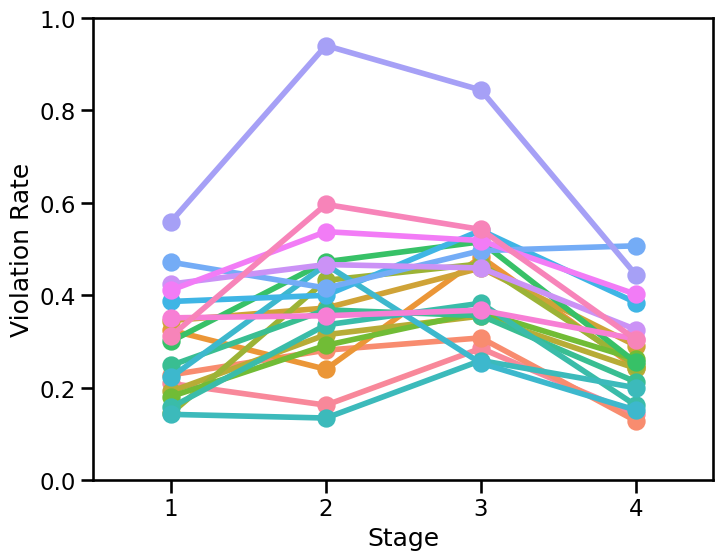

In [28]:
melted_viol_df = train_threshold_df.melt(
    id_vars=["subject_id", "max_cross_sess", "post_train_hit"],
    value_vars=["viol_stage_1", "viol_stage_2", "viol_stage_3", "viol_stage_4"],
    var_name="stage_viol",
    value_name="viol_rate",
)

# Create the catplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    x="stage_viol", y="viol_rate", hue="subject_id", data=melted_viol_df, ax=ax
)
ax.set_xticklabels(["1", "2", "3", "4"])
ax.set(ylabel="Violation Rate", xlabel="Stage", ylim=(0, 1))
ax.legend_.remove()

There appears to be no relationship between violation rate & time to train


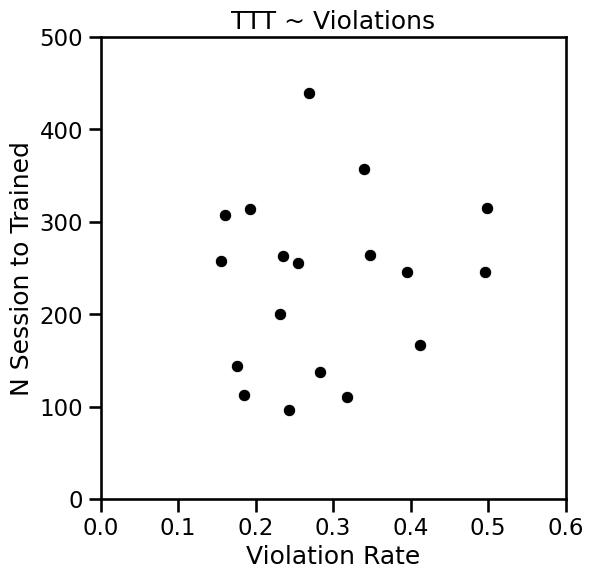

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=train_threshold_df, y="max_cross_sess", x="viol_all", color="k", ax=ax
)

_ = ax.set(
    xlim=(0, 0.6),
    ylim=(0, 500),
    ylabel="N Session to Trained",
    xlabel="Violation Rate",
    title="TTT ~ Violations",
)

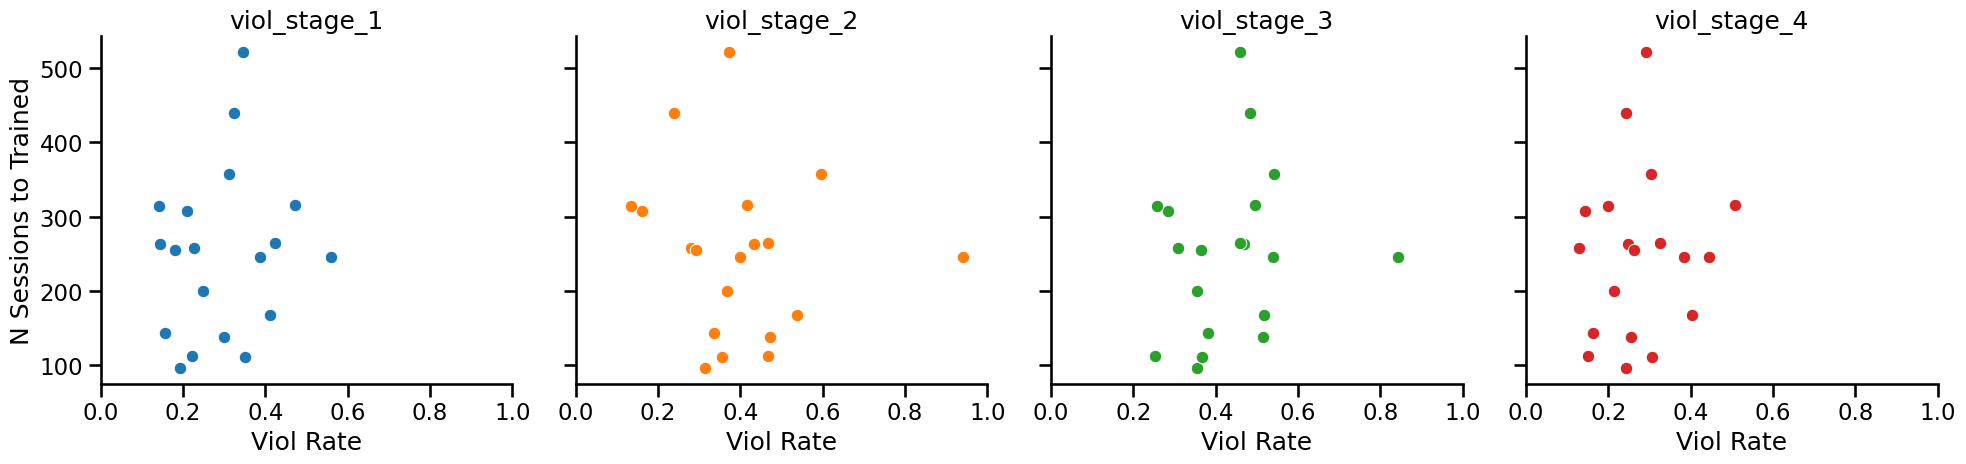

In [30]:
g = sns.FacetGrid(
    data=melted_viol_df,
    col="stage_viol",
    hue="stage_viol",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1),
)
g.map(sns.scatterplot, "viol_rate", "max_cross_sess")

g.set_axis_labels(x_var="Viol Rate", y_var="N Sessions to Trained")
g.set_titles("{col_name}")

It appears that later in training (stage 3, 4) there is a stronger relationship between violation rate and final performance.


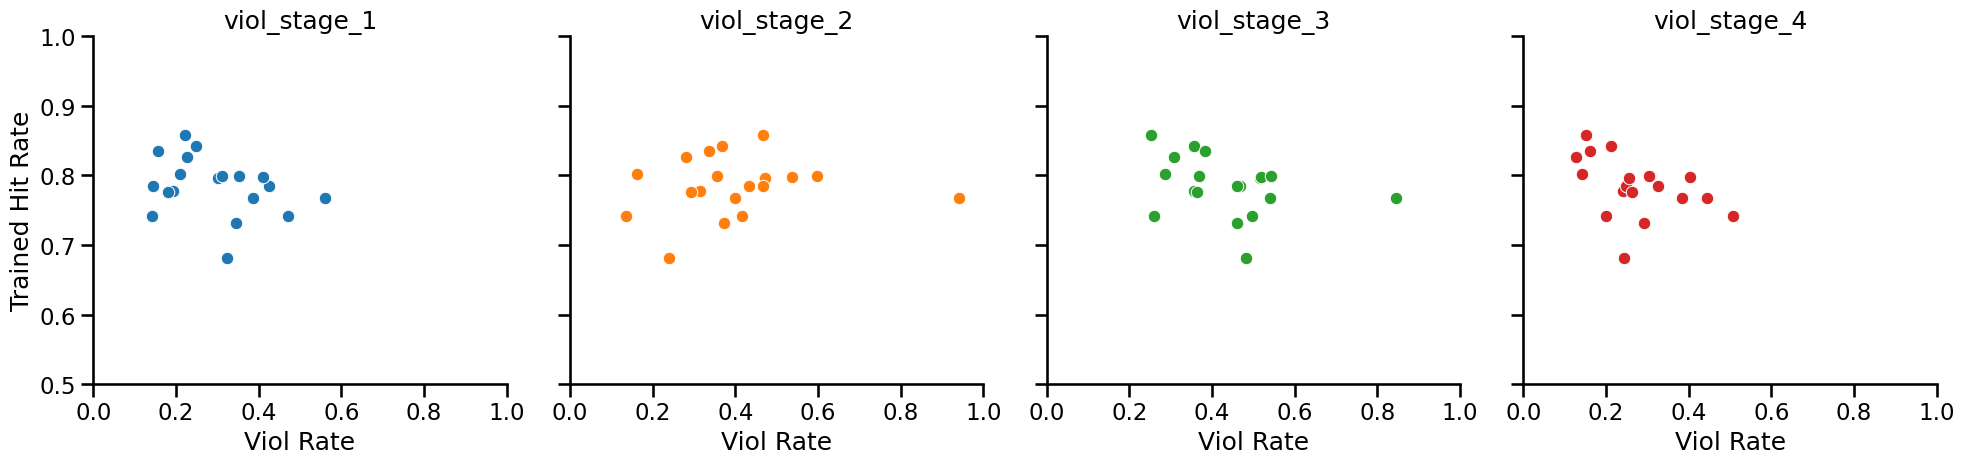

In [31]:
g = sns.FacetGrid(
    data=melted_viol_df,
    col="stage_viol",
    hue="stage_viol",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1),
    ylim=(0.5, 1),
)
g.map(sns.scatterplot, "viol_rate", "post_train_hit")

g.set_axis_labels(x_var="Viol Rate", y_var="Trained Hit Rate")
g.set_titles("{col_name}")

Performance in earlier stages doesn't appear to predict final stage performance.

> Future Idea: what about final performance in stage 3 ie when the animal moved to stage 4.

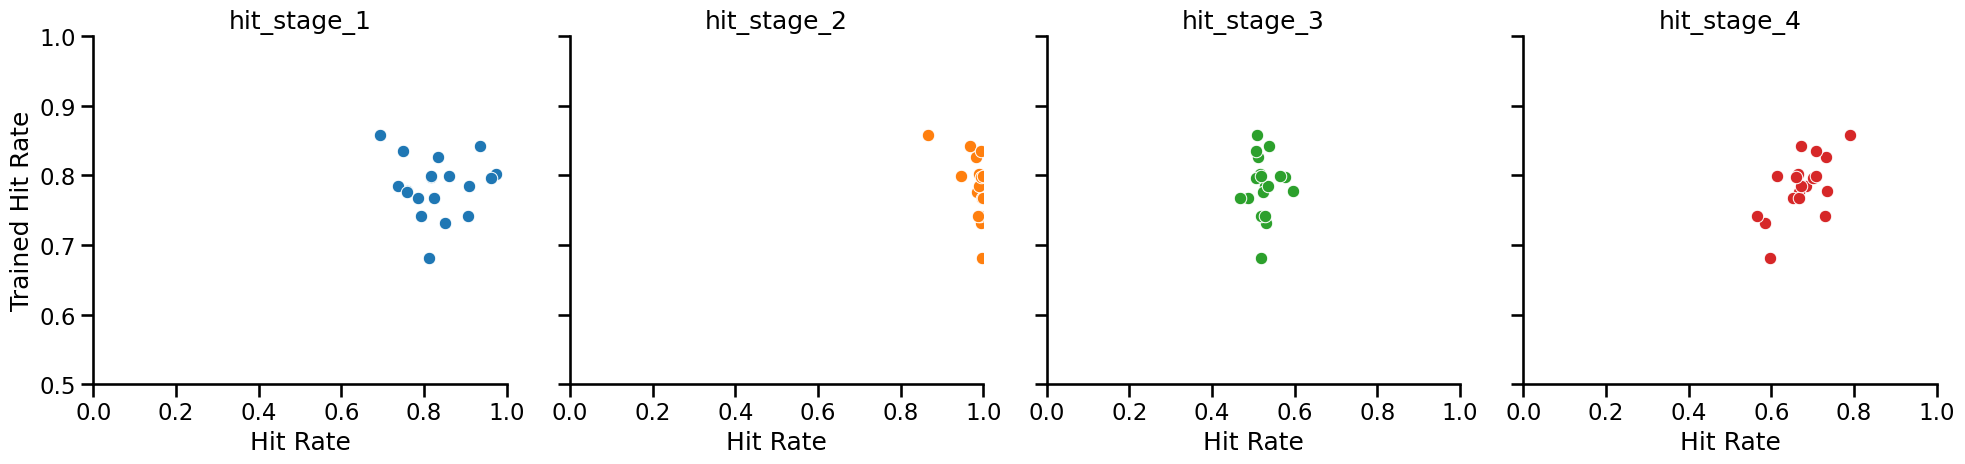

In [32]:
melted_hit_df = train_threshold_df.melt(
    id_vars=["subject_id", "max_cross_sess", "post_train_hit"],
    value_vars=["hit_stage_1", "hit_stage_2", "hit_stage_3", "hit_stage_4"],
    var_name="stage_hit",
    value_name="hit_rate",
)

g = sns.FacetGrid(
    data=melted_hit_df,
    col="stage_hit",
    hue="stage_hit",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1),
    ylim=(0.5, 1),
)
g.map(sns.scatterplot, "hit_rate", "post_train_hit")

g.set_axis_labels(x_var="Hit Rate", y_var="Trained Hit Rate")
g.set_titles("{col_name}")

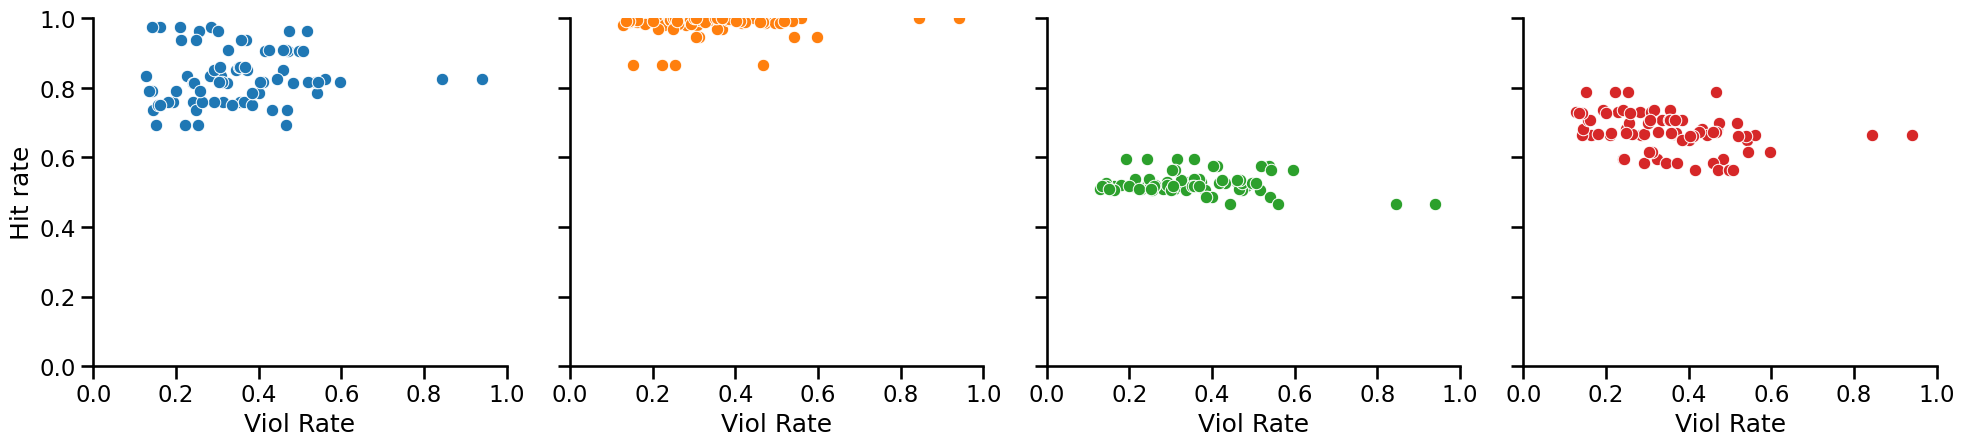

In [33]:
merge_melted_dfs = melted_hit_df.merge(melted_viol_df, on=["subject_id", "max_cross_sess", "post_train_hit"])

g = sns.FacetGrid(
    data=merge_melted_dfs,
    col="stage_hit",
    hue="stage_hit",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1),
    ylim=(0, 1),
)
g.map(sns.scatterplot, "viol_rate", "hit_rate")

g.set_axis_labels(x_var="Viol Rate", y_var="Hit rate")
g.set_titles("")



## Sounds


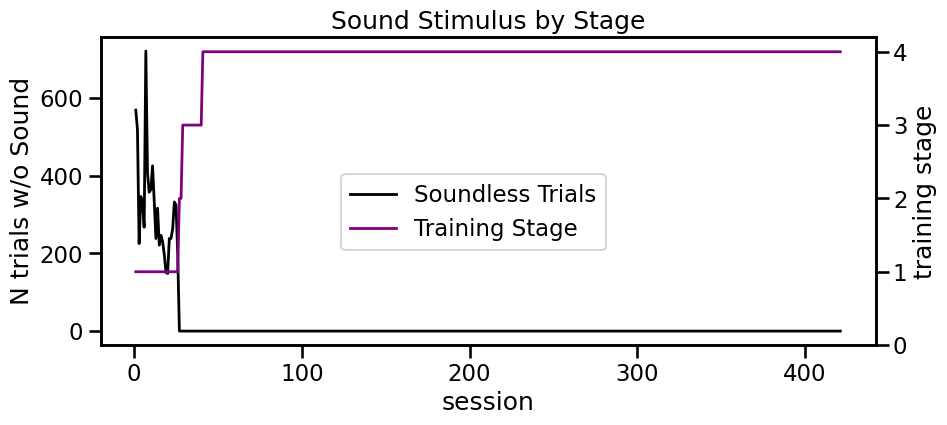

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    W080_df["s_a"].isnull().groupby(W080_df["session"]).sum(),
    ax=ax,
    color="black",
    linewidth=2,
    label="Soundless Trials",
    legend=False,
)

ax2 = plt.twinx()
sns.lineplot(
    W080_df.groupby("session").training_stage.max(),
    ax=ax2,
    color="purple",
    linewidth=2,
    label="Training Stage",
    legend=False,
)

ax.set(ylabel="N trials w/o Sound", title="Sound Stimulus by Stage")
ax2.set(ylabel="training stage", ylim=(0, 4.2))
fig.legend(loc="center")

## Mistrials


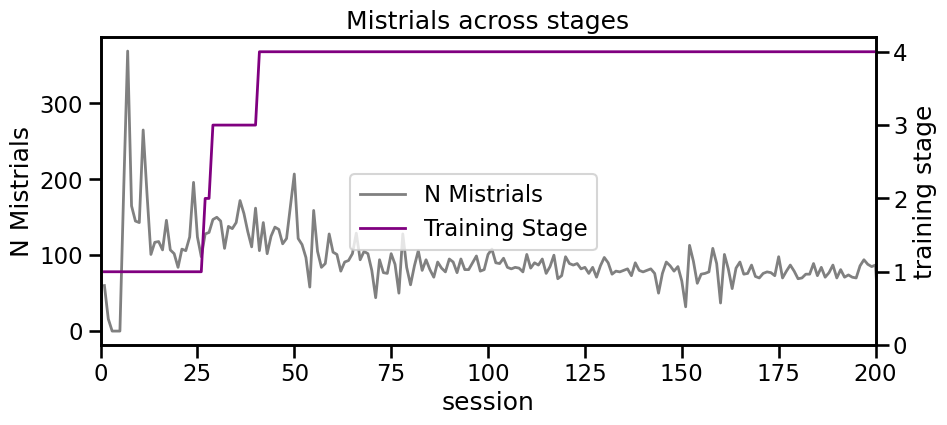

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    W080_df["hit"].isnull().groupby(W080_df["session"]).sum(),
    ax=ax,
    color="gray",
    linewidth=2,
    label="N Mistrials",
    legend=False,
)
ax.set_xlim(0, 200)
ax2 = plt.twinx()
sns.lineplot(
    W080_df.groupby("session").training_stage.max(),
    ax=ax2,
    color="purple",
    linewidth=2,
    label="Training Stage",
    legend=False,
)

ax.set(ylabel="N Mistrials", title="Mistrials across stages")
ax2.set(ylabel="training stage", ylim=(0, 4.2))
fig.legend(loc="center")

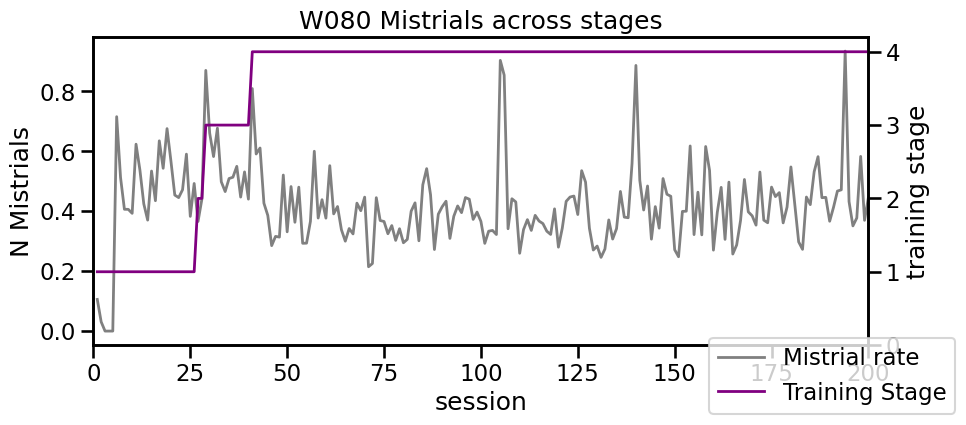

In [36]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    W080_df["hit"].isnull().groupby(W080_df["session"]).mean(),
    ax=ax,
    color="gray",
    linewidth=2,
    label="Mistrial rate",
    legend=False,
)
ax.set_xlim(0, 200)
ax2 = plt.twinx()
sns.lineplot(
    W080_df.groupby("session").training_stage.max(),
    ax=ax2,
    color="purple",
    linewidth=2,
    label="Training Stage",
    legend=False,
)

ax.set(ylabel="N Mistrials", title="W080 Mistrials across stages")
ax2.set(ylabel="training stage", ylim=(0, 4.2))
fig.legend(loc="lower right")

### Session for violation cut off


In [37]:
W080_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97696 entries, 0 to 97695
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   subject_id          97696 non-null  string  
 1   session             97696 non-null  int64   
 2   trial               97696 non-null  int64   
 3   s_a                 89491 non-null  float64 
 4   s_b                 89491 non-null  float64 
 5   choice              78540 non-null  float64 
 6   correct_side        97696 non-null  int64   
 7   hit                 78540 non-null  float64 
 8   delay               97696 non-null  float64 
 9   training_stage      97696 non-null  int64   
 10  violation           97696 non-null  bool    
 11  n_trial             97696 non-null  int64   
 12  training_stage_cat  97696 non-null  category
dtypes: bool(1), category(1), float64(5), int64(5), string(1)
memory usage: 8.4 MB


In [38]:
def determine_session_violation_drop(animal_df, threshold=30):
    null_counts = animal_df["hit"].isnull().groupby(animal_df["session"]).sum()
    mask = (null_counts.index > threshold) & (null_counts == 0)
    return mask.argmax()  # first session where there is 0 violations


def determine_stage_violation_drop(animal_df, session_drop):
    return animal_df.query(f"session == {session_drop}").training_stage.max()


def determine_average_hits_violation_drop(animal_df, session_drop, window=10):
    # get performance for the 10 sessions leading up to the drop
    return animal_df.query(
        f"session > {session_drop-window} & session < {session_drop+1}"
    ).hit.mean()


def determine_average_viols_violation_drop(animal_df, session_drop, window=10):
    # get performance for the 10 sessions leading up to the drop
    return animal_df.query(
        f"session > {session_drop-window} & session < {session_drop+1}"
    ).violation.mean()


def determine_total_trials_violation_drop(animal_df, session_drop):
    return len(animal_df.query(f"session < {session_drop}"))


def determine_stage_4_trials_violation_drop(animal_df, session_drop):
    return len(animal_df.query(f"session < {session_drop} & training_stage == 4"))

In [39]:
len(W080_df.query(f"session < {200} & training_stage == 4"))

36295

In [40]:
viol_df = (
    RAT_DF.groupby("subject_id")
    .apply(
        lambda group: pd.Series(
            {
                "animal_id": group.name,
                "session_viol_drop": determine_session_violation_drop(group),
                "stage_viol_drop": determine_stage_violation_drop(
                    group, determine_session_violation_drop(group)
                ),
                "hit_viol_drop": determine_average_hits_violation_drop(
                    group, determine_session_violation_drop(group), window=10
                ),
                "viol_viol_drop": determine_average_viols_violation_drop(
                    group, determine_session_violation_drop(group), window=10
                ),
                "n_trials_viol_drop": determine_total_trials_violation_drop(
                    group, determine_session_violation_drop(group)
                ),
                "n_stage_4_trials_viol_drop": determine_stage_4_trials_violation_drop(
                    group, determine_session_violation_drop(group)
                ),
            }
        )
    )
    .reset_index(drop=True)
)

In [41]:
viol_df.head()

animal_id  session_viol_drop  stage_viol_drop  hit_viol_drop   
0      W051                196                4       0.631285  \
1      W060                199                4       0.751385   
2      W061                200                4       0.667571   
3      W062                199                4       0.614017   
4      W065                199                4       0.781170   

   viol_viol_drop  n_trials_viol_drop  n_stage_4_trials_viol_drop  
0        0.272780               62110                       50406  
1        0.122722               54837                       41109  
2        0.199348               41102                       30743  
3        0.311239               34676                       23312  
4        0.239257               49843                       36812

(0.0, 230.0)

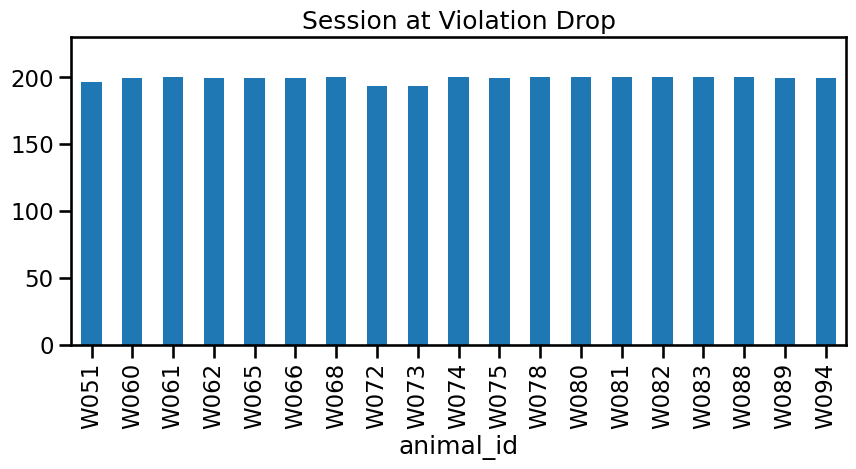

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))
viol_df.plot(
    kind="bar",
    x="animal_id",
    y="session_viol_drop",
    title="Session at Violation Drop",
    legend=False,
    ax=ax,
)
plt.ylim(0, 230)

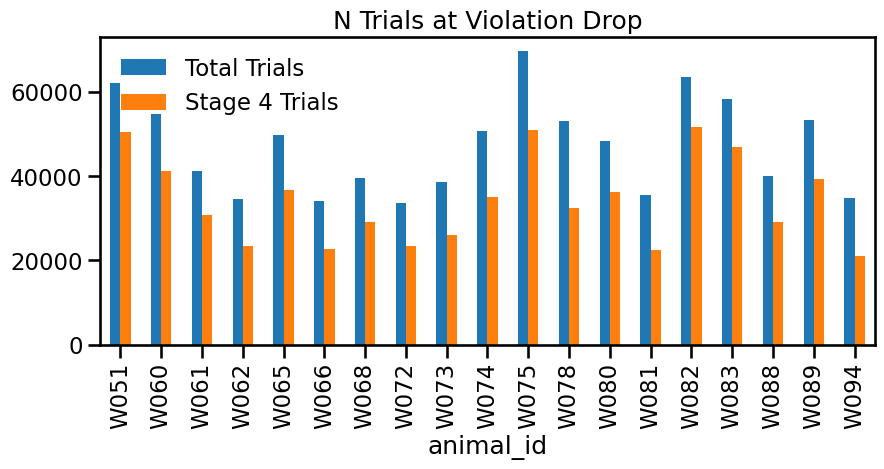

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
viol_df.plot(
    kind="bar",
    x="animal_id",
    y=["n_trials_viol_drop", "n_stage_4_trials_viol_drop"],
    title="N Trials at Violation Drop",
    label=["Total Trials", "Stage 4 Trials"],
    legend=True,
    ax=ax,
)
ax.legend(frameon=False)

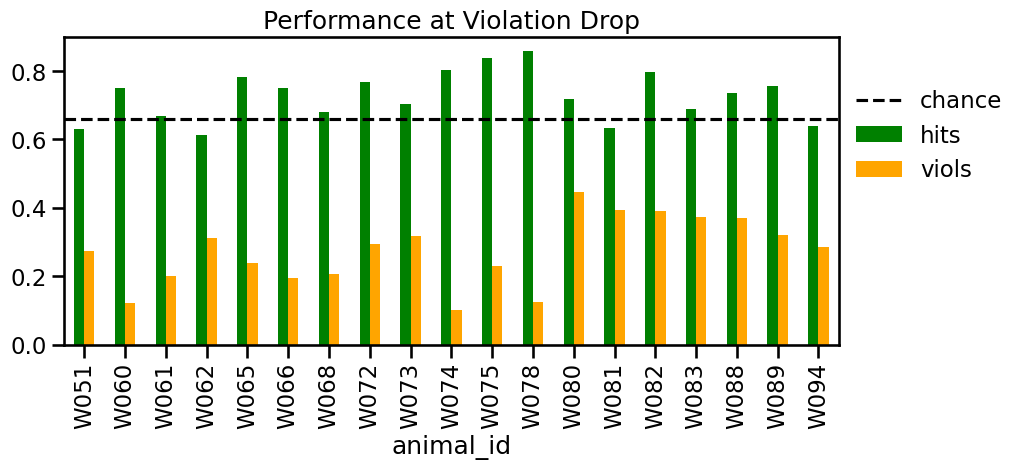

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
viol_df.plot(
    kind="bar",
    x="animal_id",
    y=["hit_viol_drop", "viol_viol_drop"],
    color=["green", "orange"],
    label=["hits", "viols"],
    legend=True,
    title="Performance at Violation Drop",
    ax=ax,
)

ax.axhline(y=0.66, color="k", linestyle="--", zorder=1, label="chance")
ax.legend(loc=(1.01, 0.5), frameon=False)

In [46]:
rat_df_w_viols

subject_id  session  trial   s_a   s_b  choice  correct_side  hit   
0             W051        1      1   NaN   NaN     1.0             0  0.0  \
1             W051        2      1   NaN   NaN     1.0             0  0.0   
2             W051        2      2   NaN   NaN     0.0             0  1.0   
3             W051        2      3   NaN   NaN     0.0             1  0.0   
4             W051        2      4   NaN   NaN     1.0             0  0.0   
...            ...      ...    ...   ...   ...     ...           ...  ...   
2461849       W094      200    112  76.0  84.0     1.0             0  0.0   
2461850       W094      200    113  68.0  60.0     1.0             1  1.0   
2461851       W094      200    114  68.0  60.0     1.0             1  1.0   
2461852       W094      200    115  68.0  60.0     1.0             1  1.0   
2461853       W094      200    116  76.0  68.0     1.0             1  1.0   

         delay  training_stage  violation  n_trial training_stage_cat  
0         1.00               1      False        0                  1  
1         0.01               1      False        1                  1  
2         0.01               1      False        2                  1  
3         0.01               1      False        3                  1  
4         0.01               1      False        4                  1  
...        ...             ...        ...      ...                ...  
2461849   3.10               4      False  2461849                  4  
2461850   3.10               4      False  2461850                  4  
2461851   4.10               4      False  2461851                  4  
2461852   4.10               4      False  2461852                  4  
2461853   3.10               4      False  2461853                  4  

[903591 rows x 13 columns]

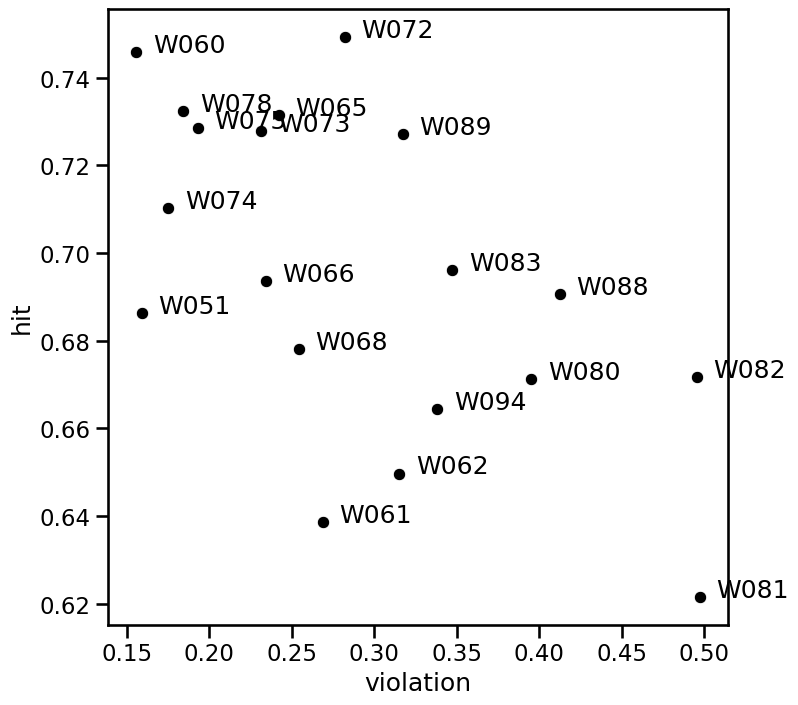

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
rat_df_w_viols = RAT_DF.query("session <= 200")
group = rat_df_w_viols[["subject_id", "hit", "violation"]].groupby("subject_id").mean()
sns.scatterplot(x=group["violation"], y=group["hit"], color="k", ax=ax)
for index, row in group.iterrows():
    ax.text(row["violation"] + 0.01, row["hit"], str(index))

In [49]:
import statsmodels.api as sm

group.reset_index(inplace=True)

X = group["violation"].values.reshape(-1, 1)
y = group["hit"].values.reshape(-1, 1)

# Add a constant term to the predictor variable
X = sm.add_constant(X)

# Create and fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     9.285
Date:                Tue, 06 Jun 2023   Prob (F-statistic):            0.00728
Time:                        10:44:52   Log-Likelihood:                 40.284
No. Observations:                  19   AIC:                            -76.57
Df Residuals:                      17   BIC:                            -74.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7564      0.021     35.713      0.0

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


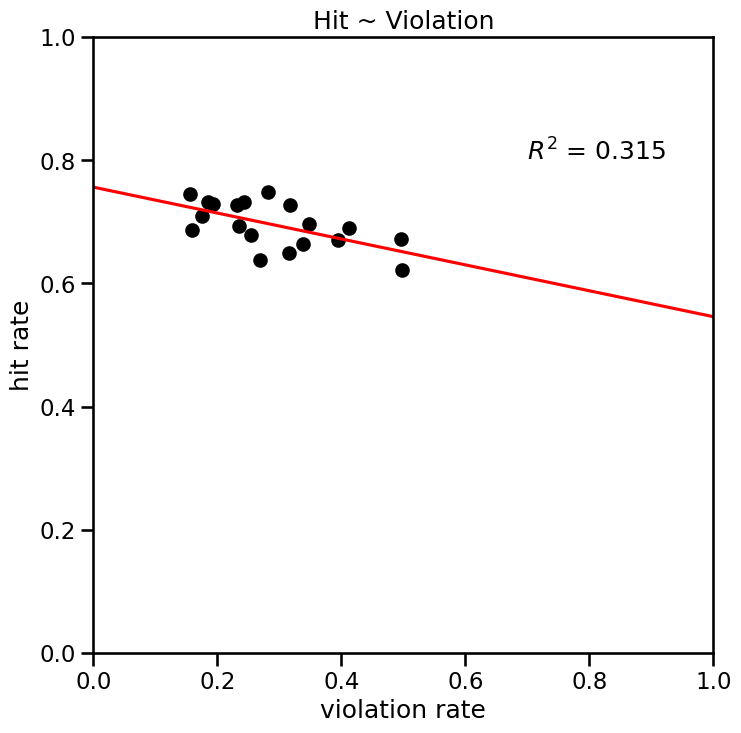

In [50]:
plt.figure(figsize=(8, 8))
slope = results.params[1]
intercept = results.params[0]

# Plot the data points
plt.scatter(group["violation"], group["hit"], color="black", label="Data")

# Plot the line model
x_line = x_line = np.linspace(0, 1, 100)

# Calculate the corresponding y-values based on the linear regression model
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color="red", label="Regression Line")

# Add labels and title
plt.xlabel("violation rate")
plt.ylabel("hit rate")
plt.title("Hit ~ Violation")
plt.ylim(0, 1)
plt.xlim(0, 1)

# Add legend
plt.text(0.7, 0.8, "$R^2$ = 0.315")
# Display the plot
plt.show()

## Delays

Number of unique delay lengths varies for each animal but the general trends are: growing in stage 1 and stage 2 (stage 2 is much shorter) and discrete delays in stage 3 and 4.


In [53]:
# get unique delay values for each animal
unique_delays = (
    RAT_DF.groupby(["subject_id", "training_stage_cat"]).delay.unique().reset_index()
)

# get the number of unique delay values for each animal
unique_delays["n_unique_delays"] = unique_delays.delay.apply(lambda x: len(x))

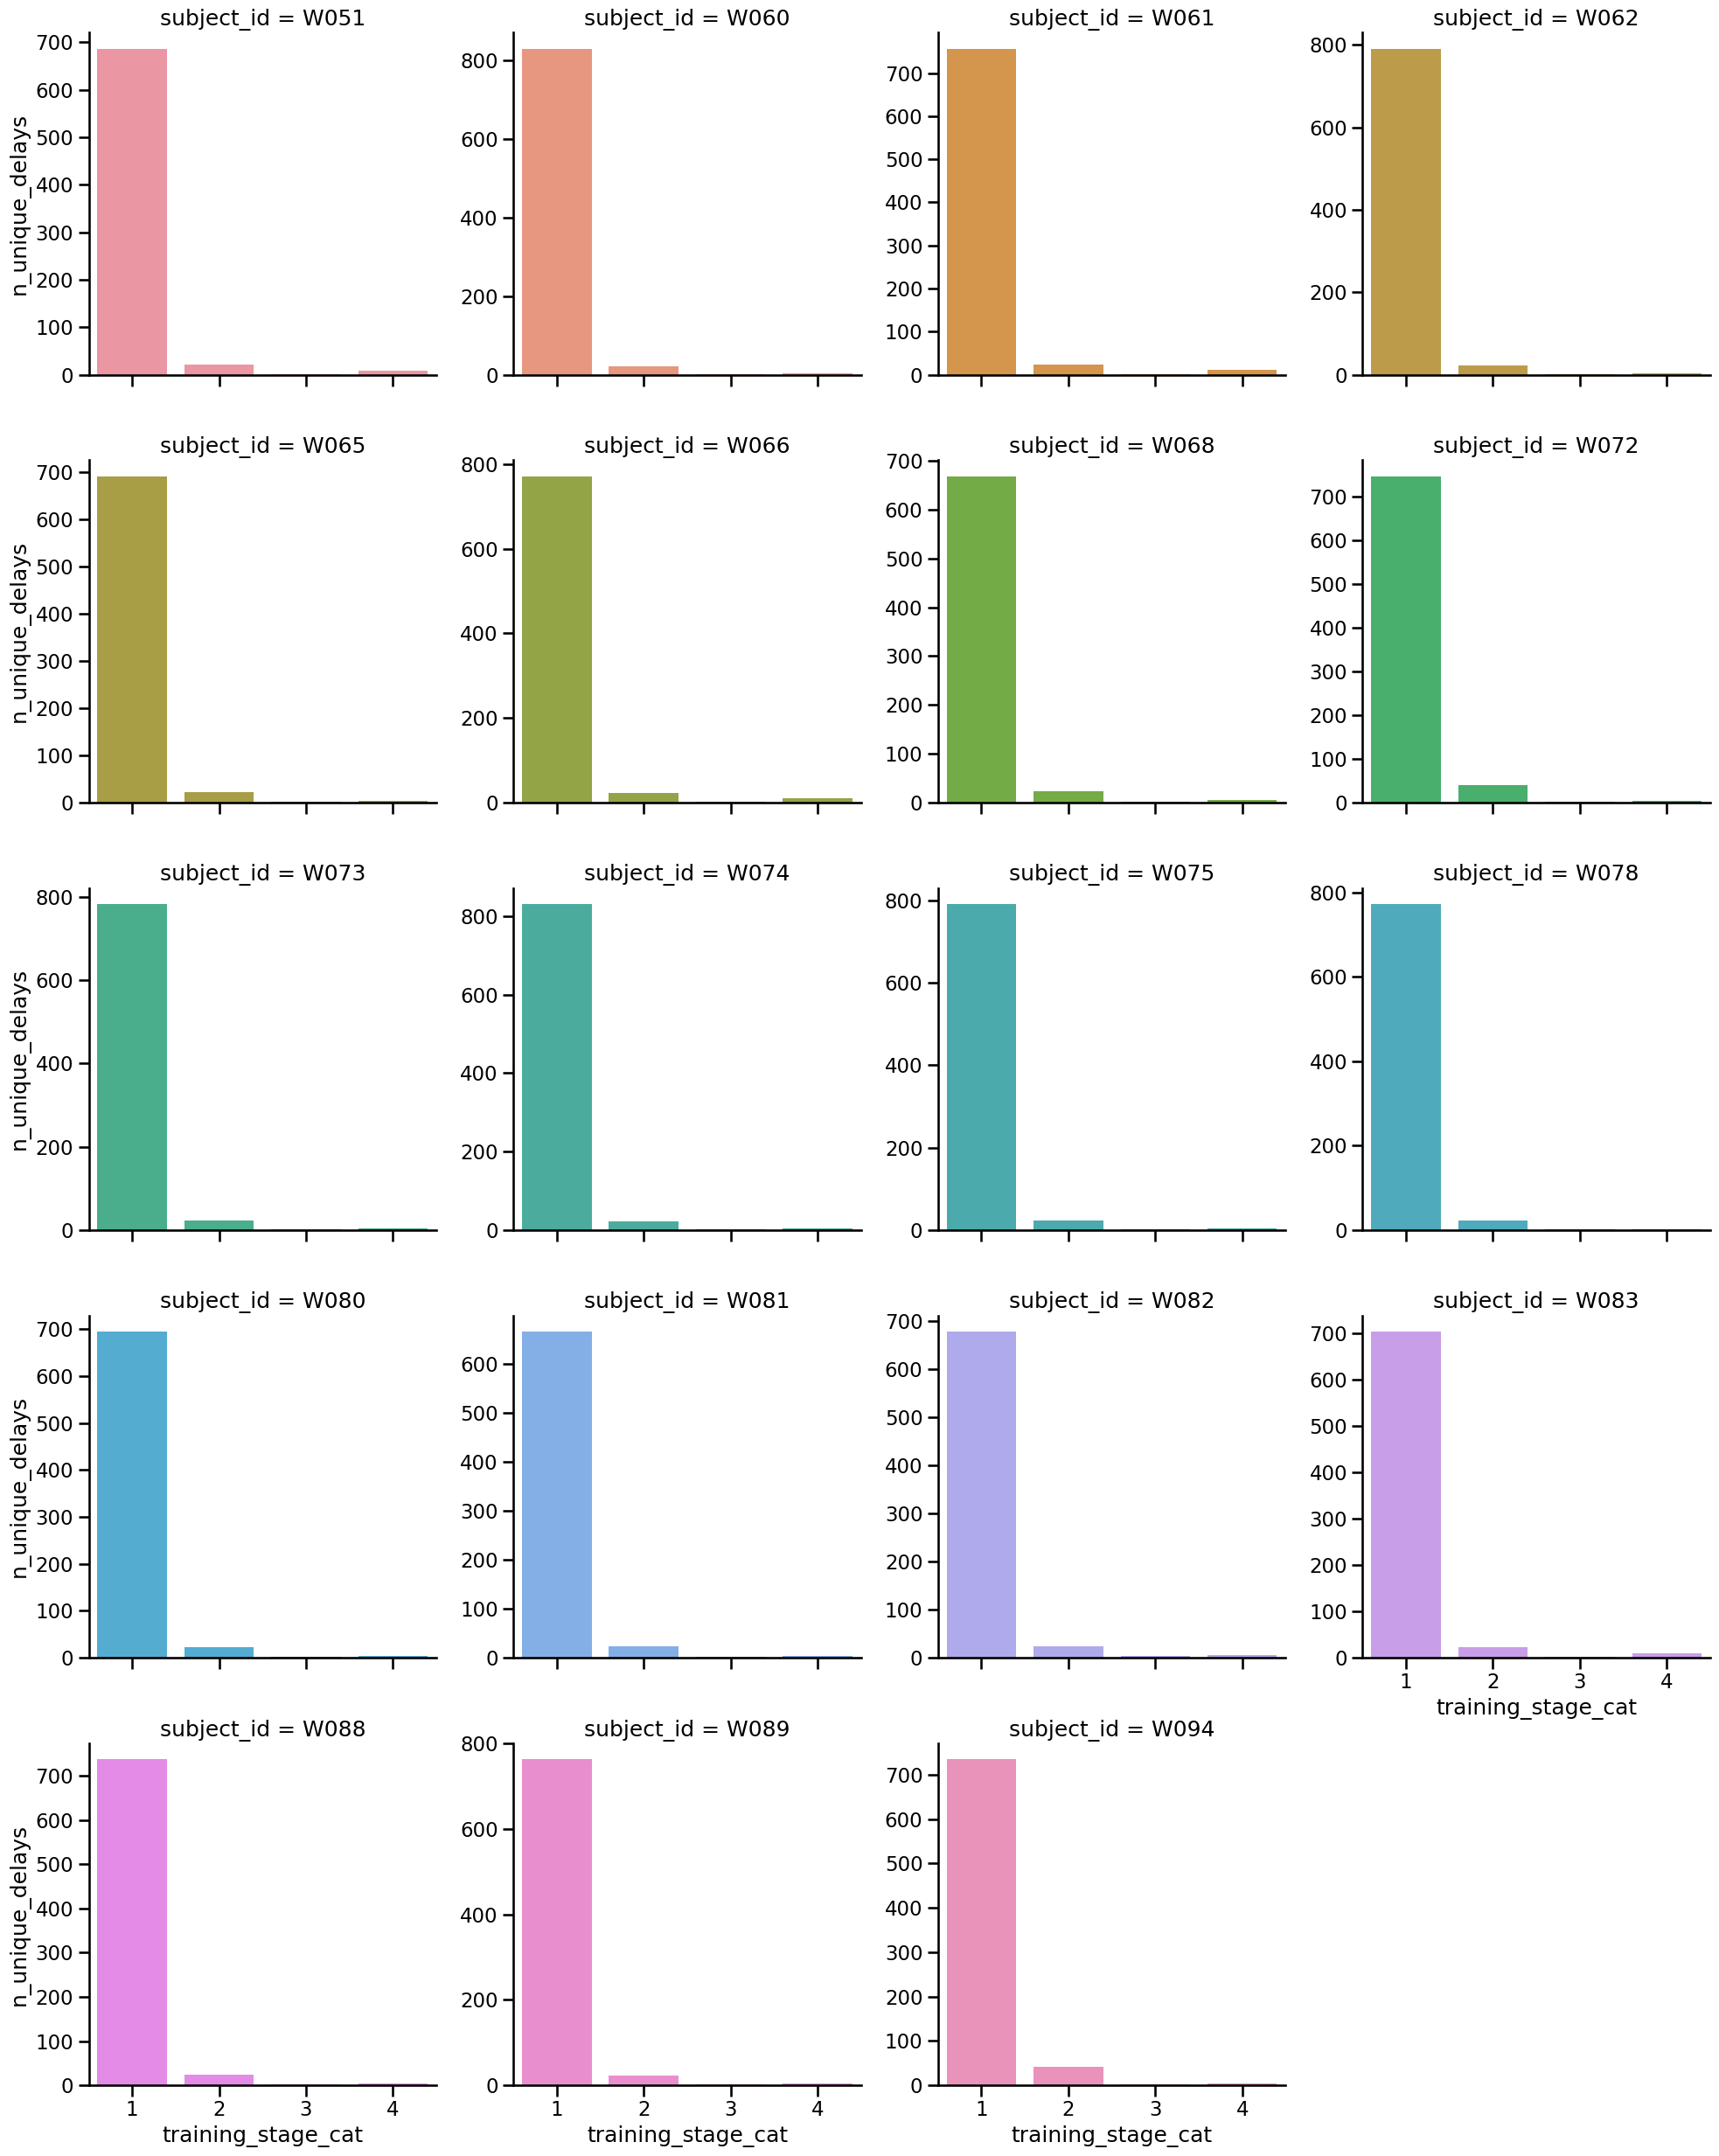

In [54]:
g = sns.catplot(
    x="training_stage_cat",
    y="n_unique_delays",
    col="subject_id",
    col_wrap=4,
    hue="subject_id",
    data=unique_delays,
    kind="bar",
    dodge=False,
    sharey=False,
)

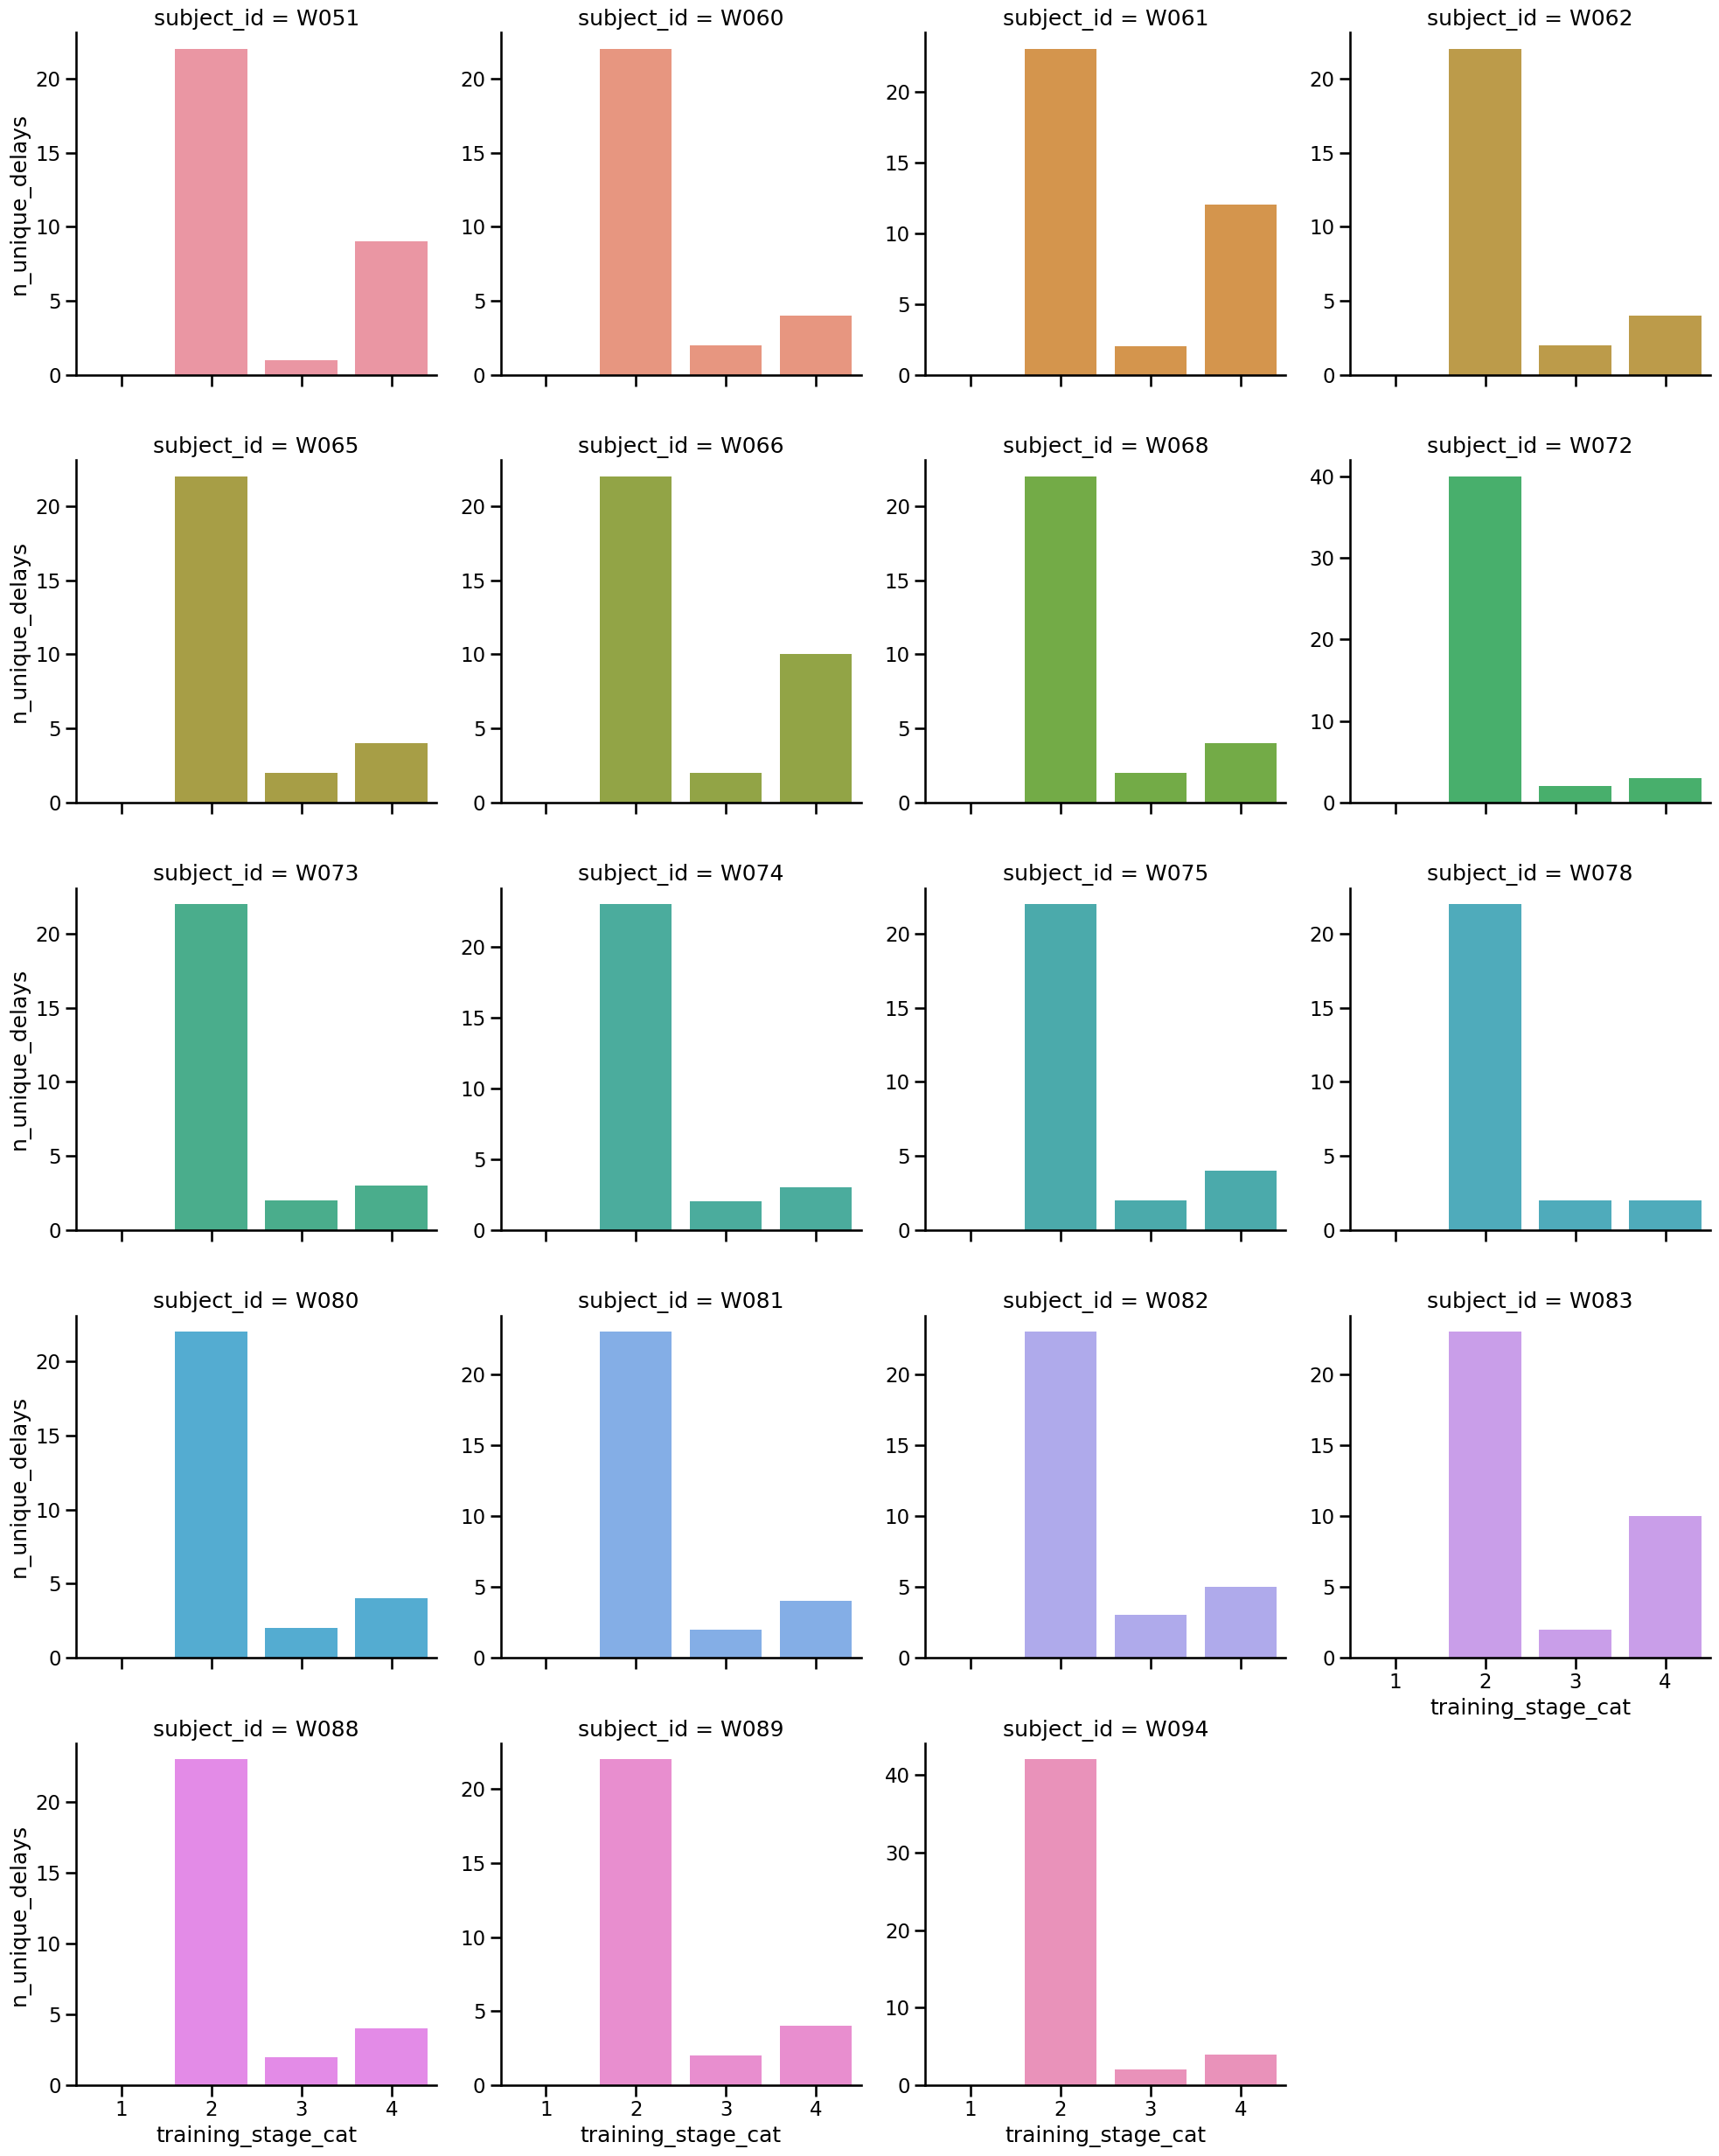

In [55]:
g = sns.catplot(
    x="training_stage_cat",
    y="n_unique_delays",
    col="subject_id",
    col_wrap=4,
    hue="subject_id",
    data=unique_delays.query("training_stage_cat != 1"),
    kind="bar",
    dodge=False,
    sharey=False,
)

Plotting average delay across sessions for each animal colored by training stage.

Things to note

- stage 1 is primary growth
- stage 2 is very short
- sometimes animals get sent back breifly to stage 1, e.g. W060
- stage 3 is quite stable
- stage 4 is the largest amount of time and the delay parameters change during it


In [56]:
rat_df_filtered = RAT_DF[RAT_DF["subject_id"].isin(["W083", "W080", "W089", "W094"])]
delay_params_df = (
    RAT_DF.groupby(["subject_id", "training_stage_cat", "session"])
    .delay.agg(["min", "max", "median"])
    .reset_index()
)

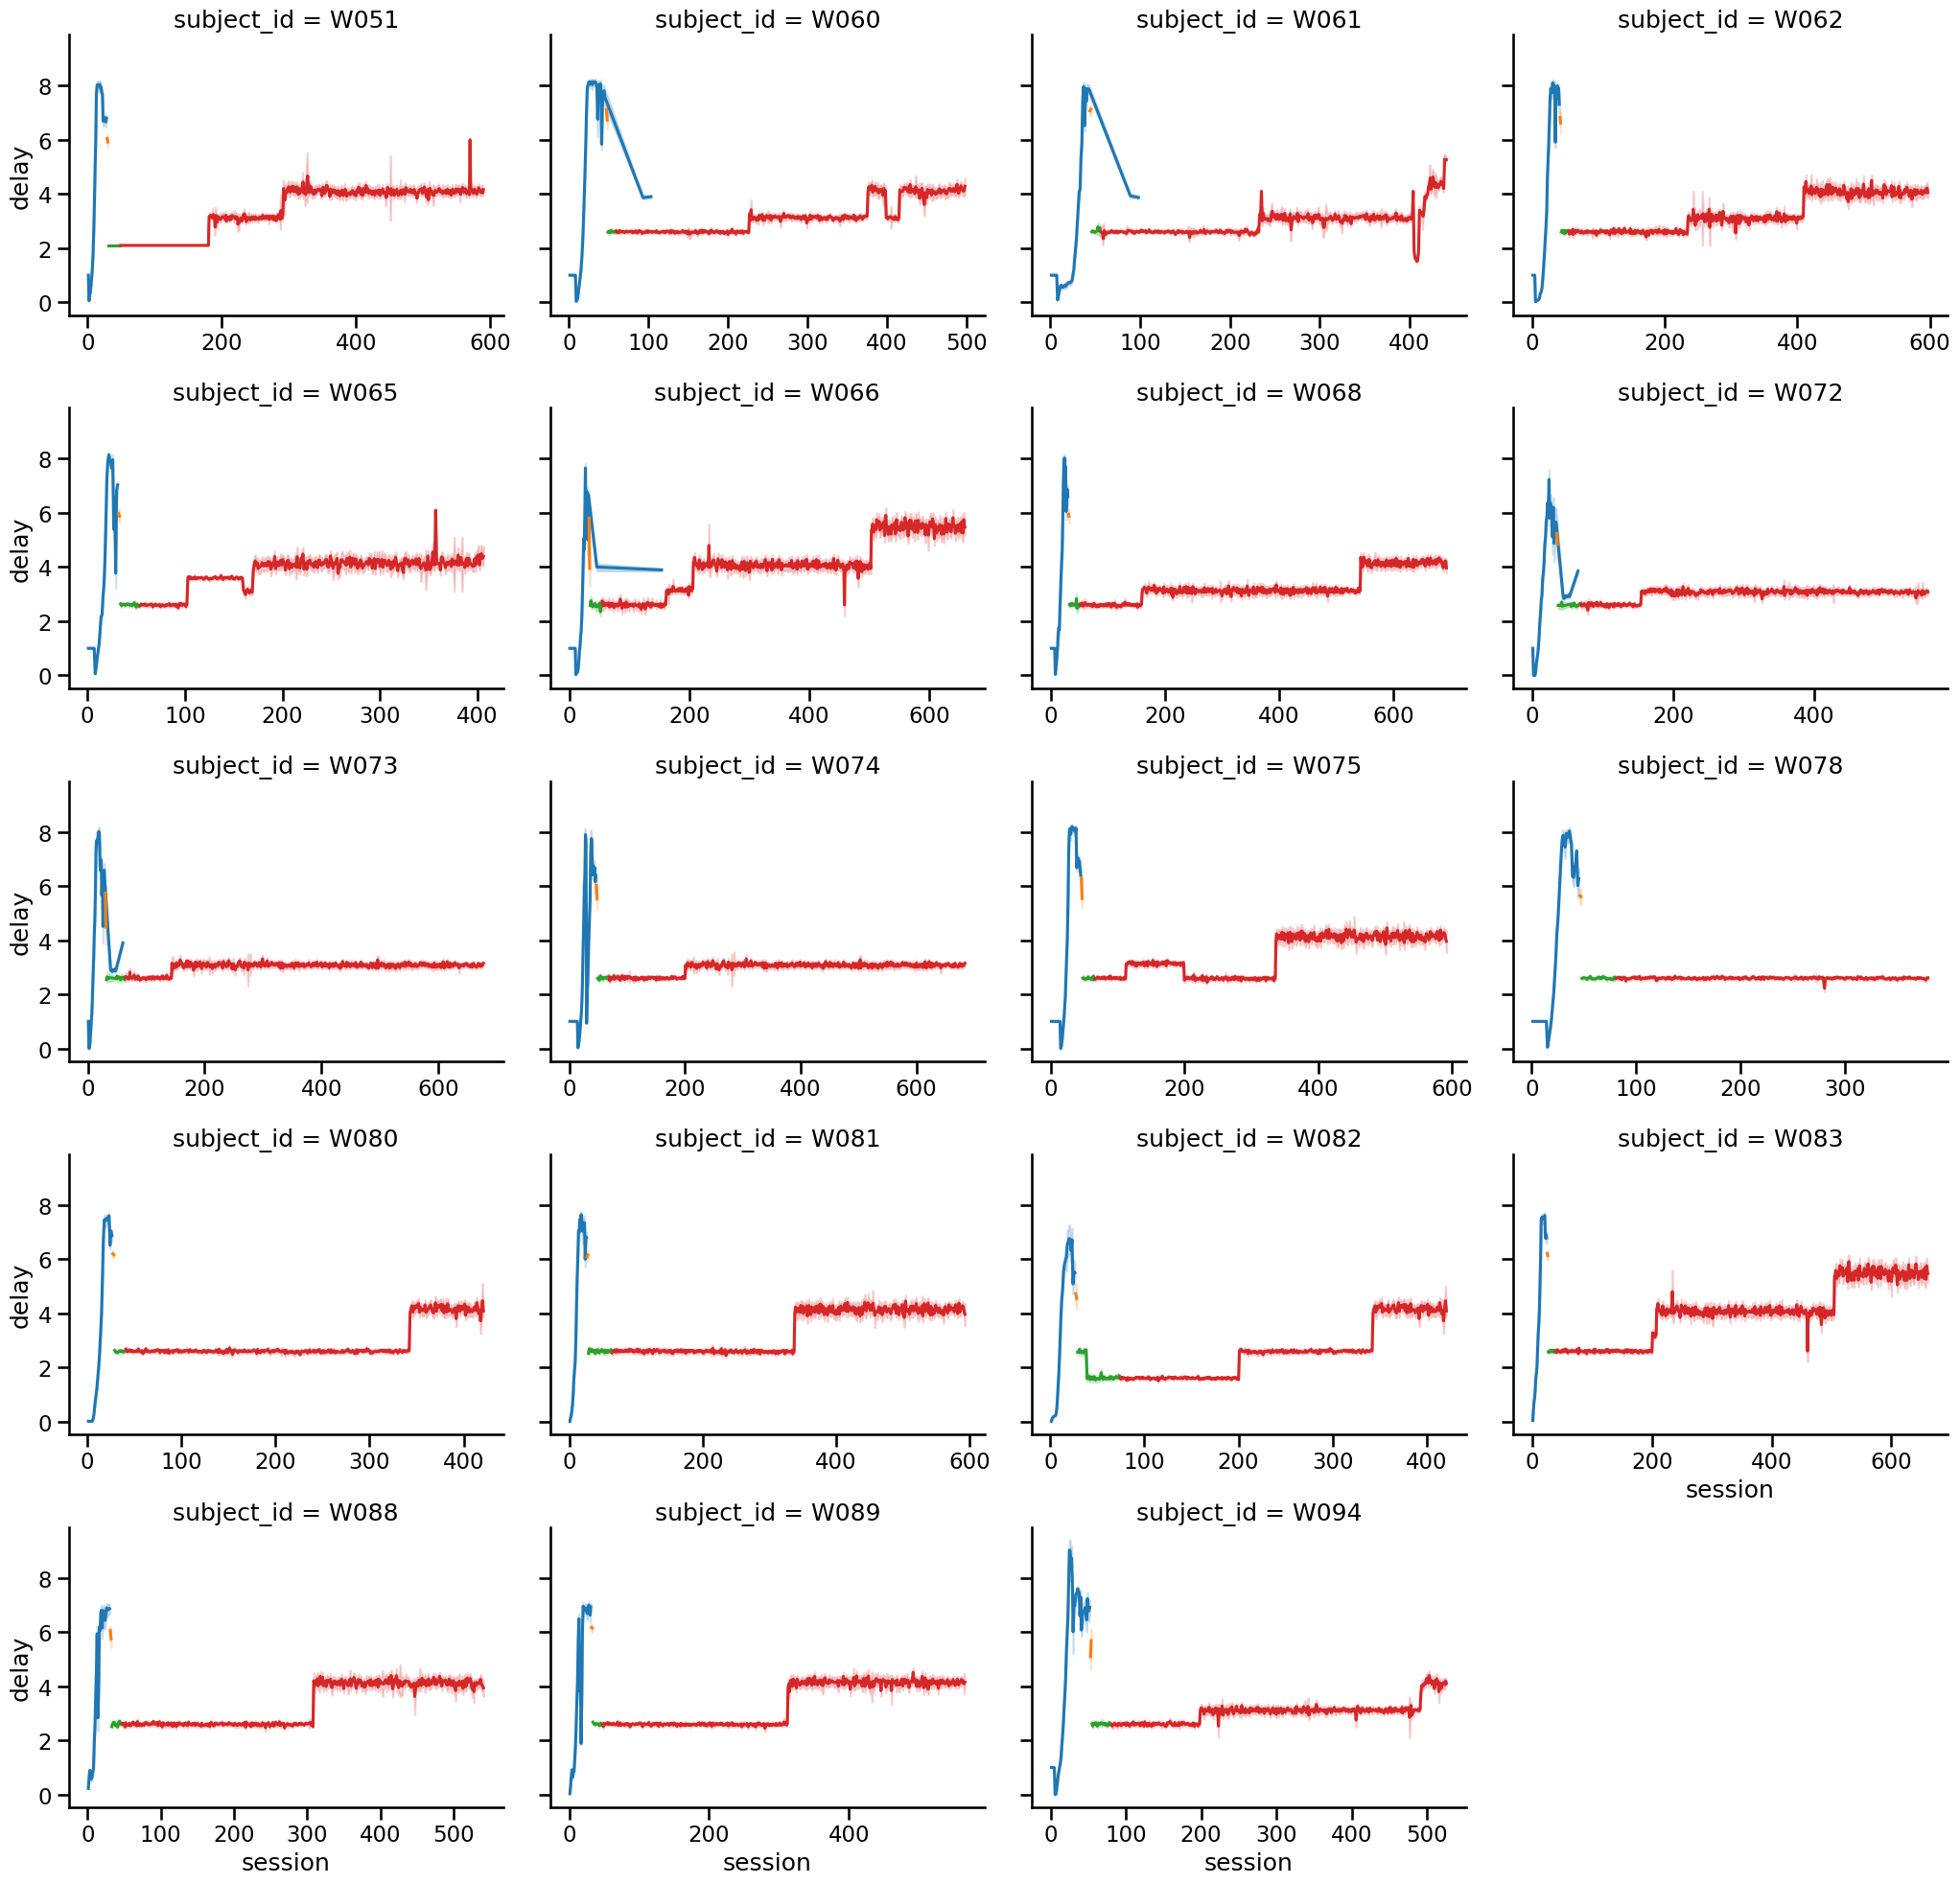

In [57]:
g = sns.FacetGrid(
    data=RAT_DF,
    col="subject_id",
    hue="training_stage",
    col_wrap=4,
    height=4,
    aspect=1.3,
    sharey=True,
    sharex=False,
)
g.map(sns.lineplot, "session", "delay")

Plotting all delay across trials for each animal, training stage

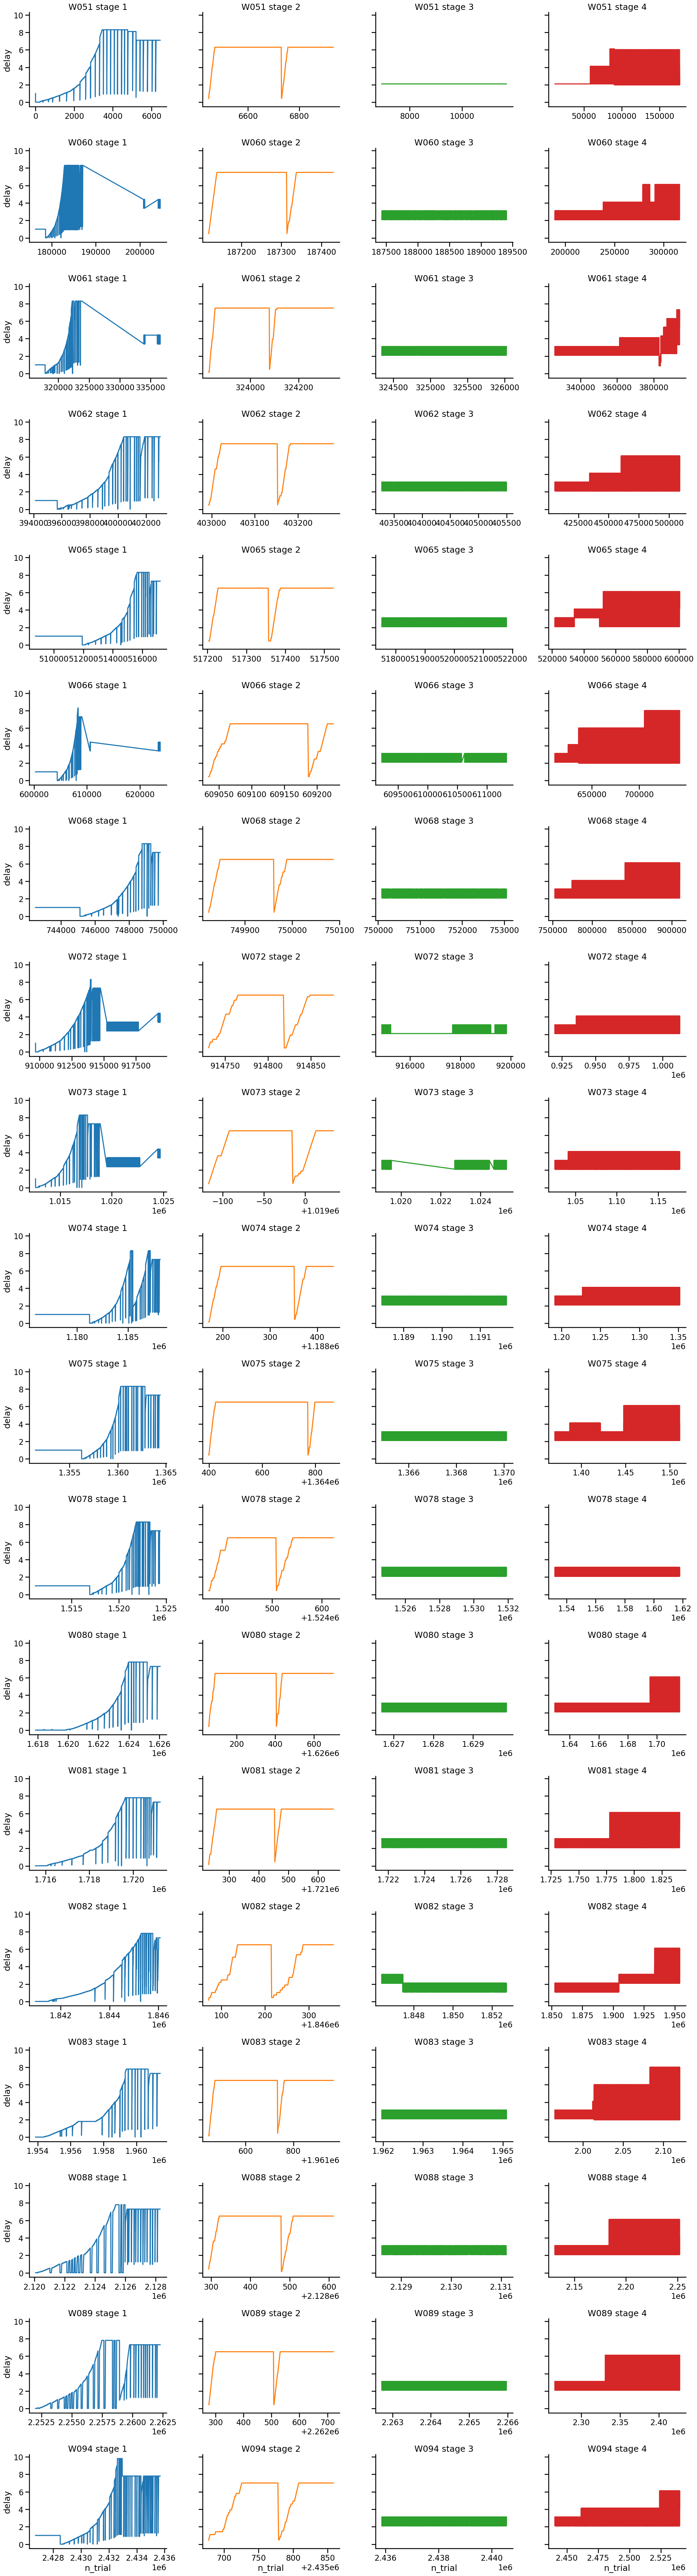

In [58]:
g = sns.FacetGrid(
    data=RAT_DF,
    row="subject_id",
    col="training_stage_cat",
    hue="training_stage_cat",
    sharey=True,
    sharex=False,
    height=4,
    aspect=1.3,
)
g.map(sns.lineplot, "n_trial", "delay")
g.set_titles("{row_name} stage {col_name}")

Plotting histogram of delay times by stage, animal

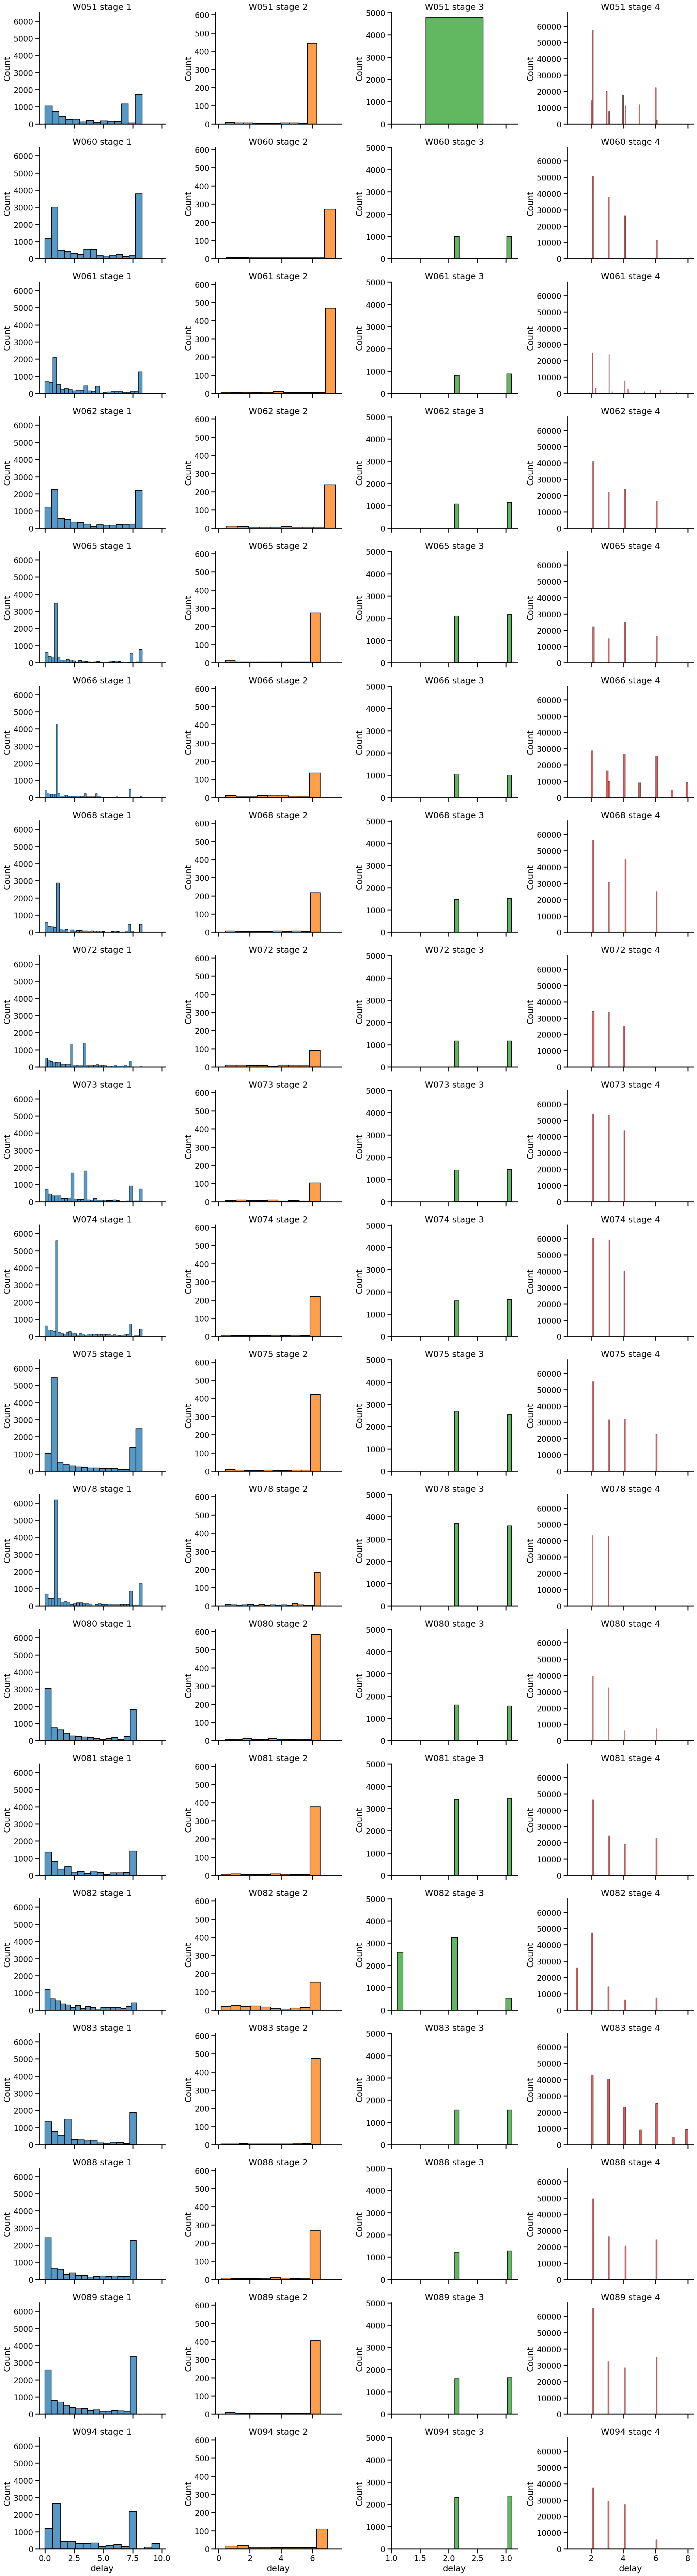

In [59]:
g = sns.FacetGrid(
    data=RAT_DF,
    row="subject_id",
    col="training_stage_cat",
    hue="training_stage_cat",
    sharey="col",
    sharex="col",
    height=4,
    aspect=1.3,
)
g.map(sns.histplot, "delay")
g.set_titles("{row_name} stage {col_name}")

Plotting performance by delay length

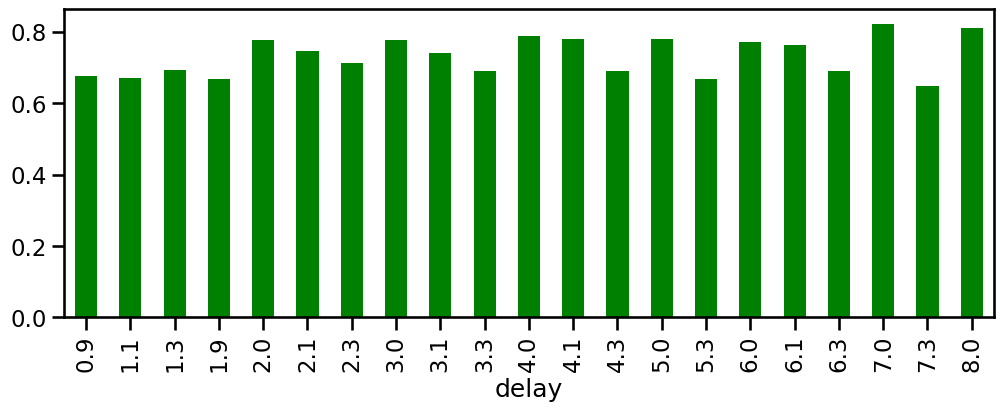

In [60]:
discrete_delay_df = RAT_DF.query("training_stage >=  3").groupby(["delay"]).hit.mean().reset_index()
discrete_delay_df.delay = discrete_delay_df.delay.round(2)
discrete_delay_df.plot(kind="bar", x="delay", y="hit", color='green', figsize=(12, 4))
plt.gca().legend().remove()

[Text(0.5, 1.0, 'Stage 3+ Hit Rates ~ Delay'), (0.0, 1.0)]

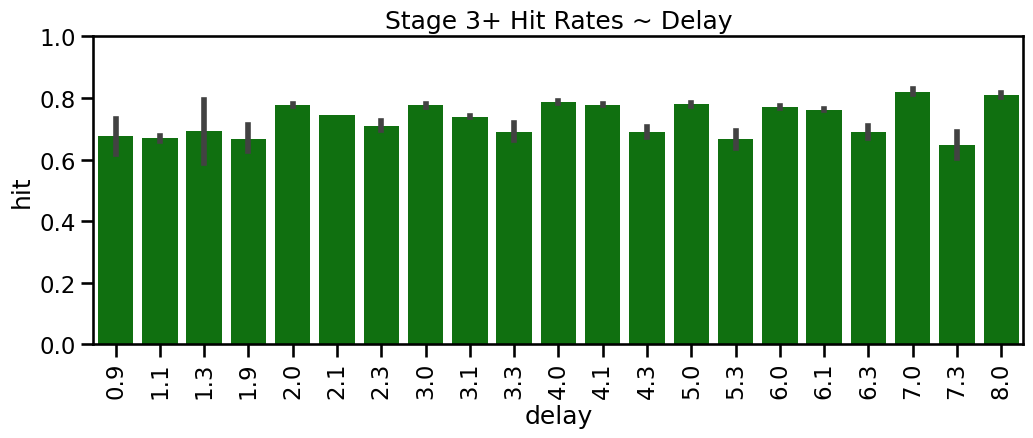

In [61]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=RAT_DF.query("training_stage >=  3"), x="delay", y="hit", color='green',ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="Stage 3+ Hit Rates ~ Delay", ylim=(0, 1))

[Text(0.5, 1.0, 'Stage 3+ Hit Rates ~ Delay'), (0.0, 1.0)]

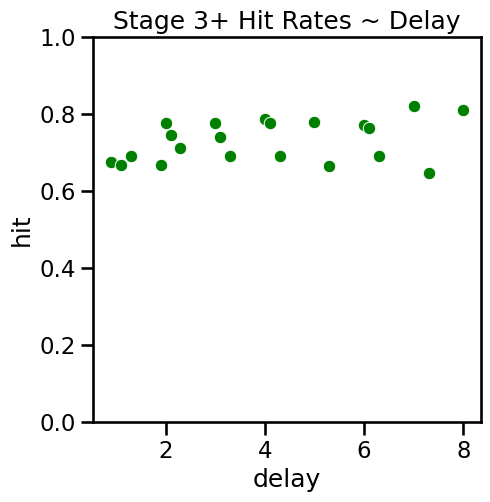

In [62]:
fig,ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=RAT_DF.query("training_stage >=  3").groupby('delay').hit.mean().reset_index(), x="delay", y="hit", color='green',ax=ax)
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="Stage 3+ Hit Rates ~ Delay", ylim=(0, 1))

There's not enough information for violation rates to assess the two together

<Axes: xlabel='delay'>

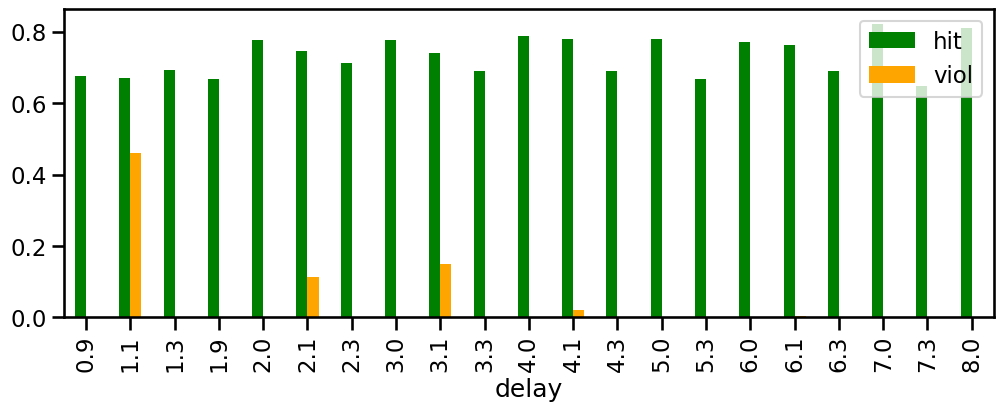

In [63]:
discrete_delay_df = RAT_DF.query("training_stage >=  3").groupby(["delay"]).hit.mean().reset_index()
discrete_delay_df['viol'] =  RAT_DF.query("training_stage >=  3").groupby(["delay"]).violation.mean().values
discrete_delay_df.plot(kind="bar", x="delay", y=["hit", "viol"], color=["green", "orange"], figsize=(12, 4))

Plotting delay length by performance for each animal

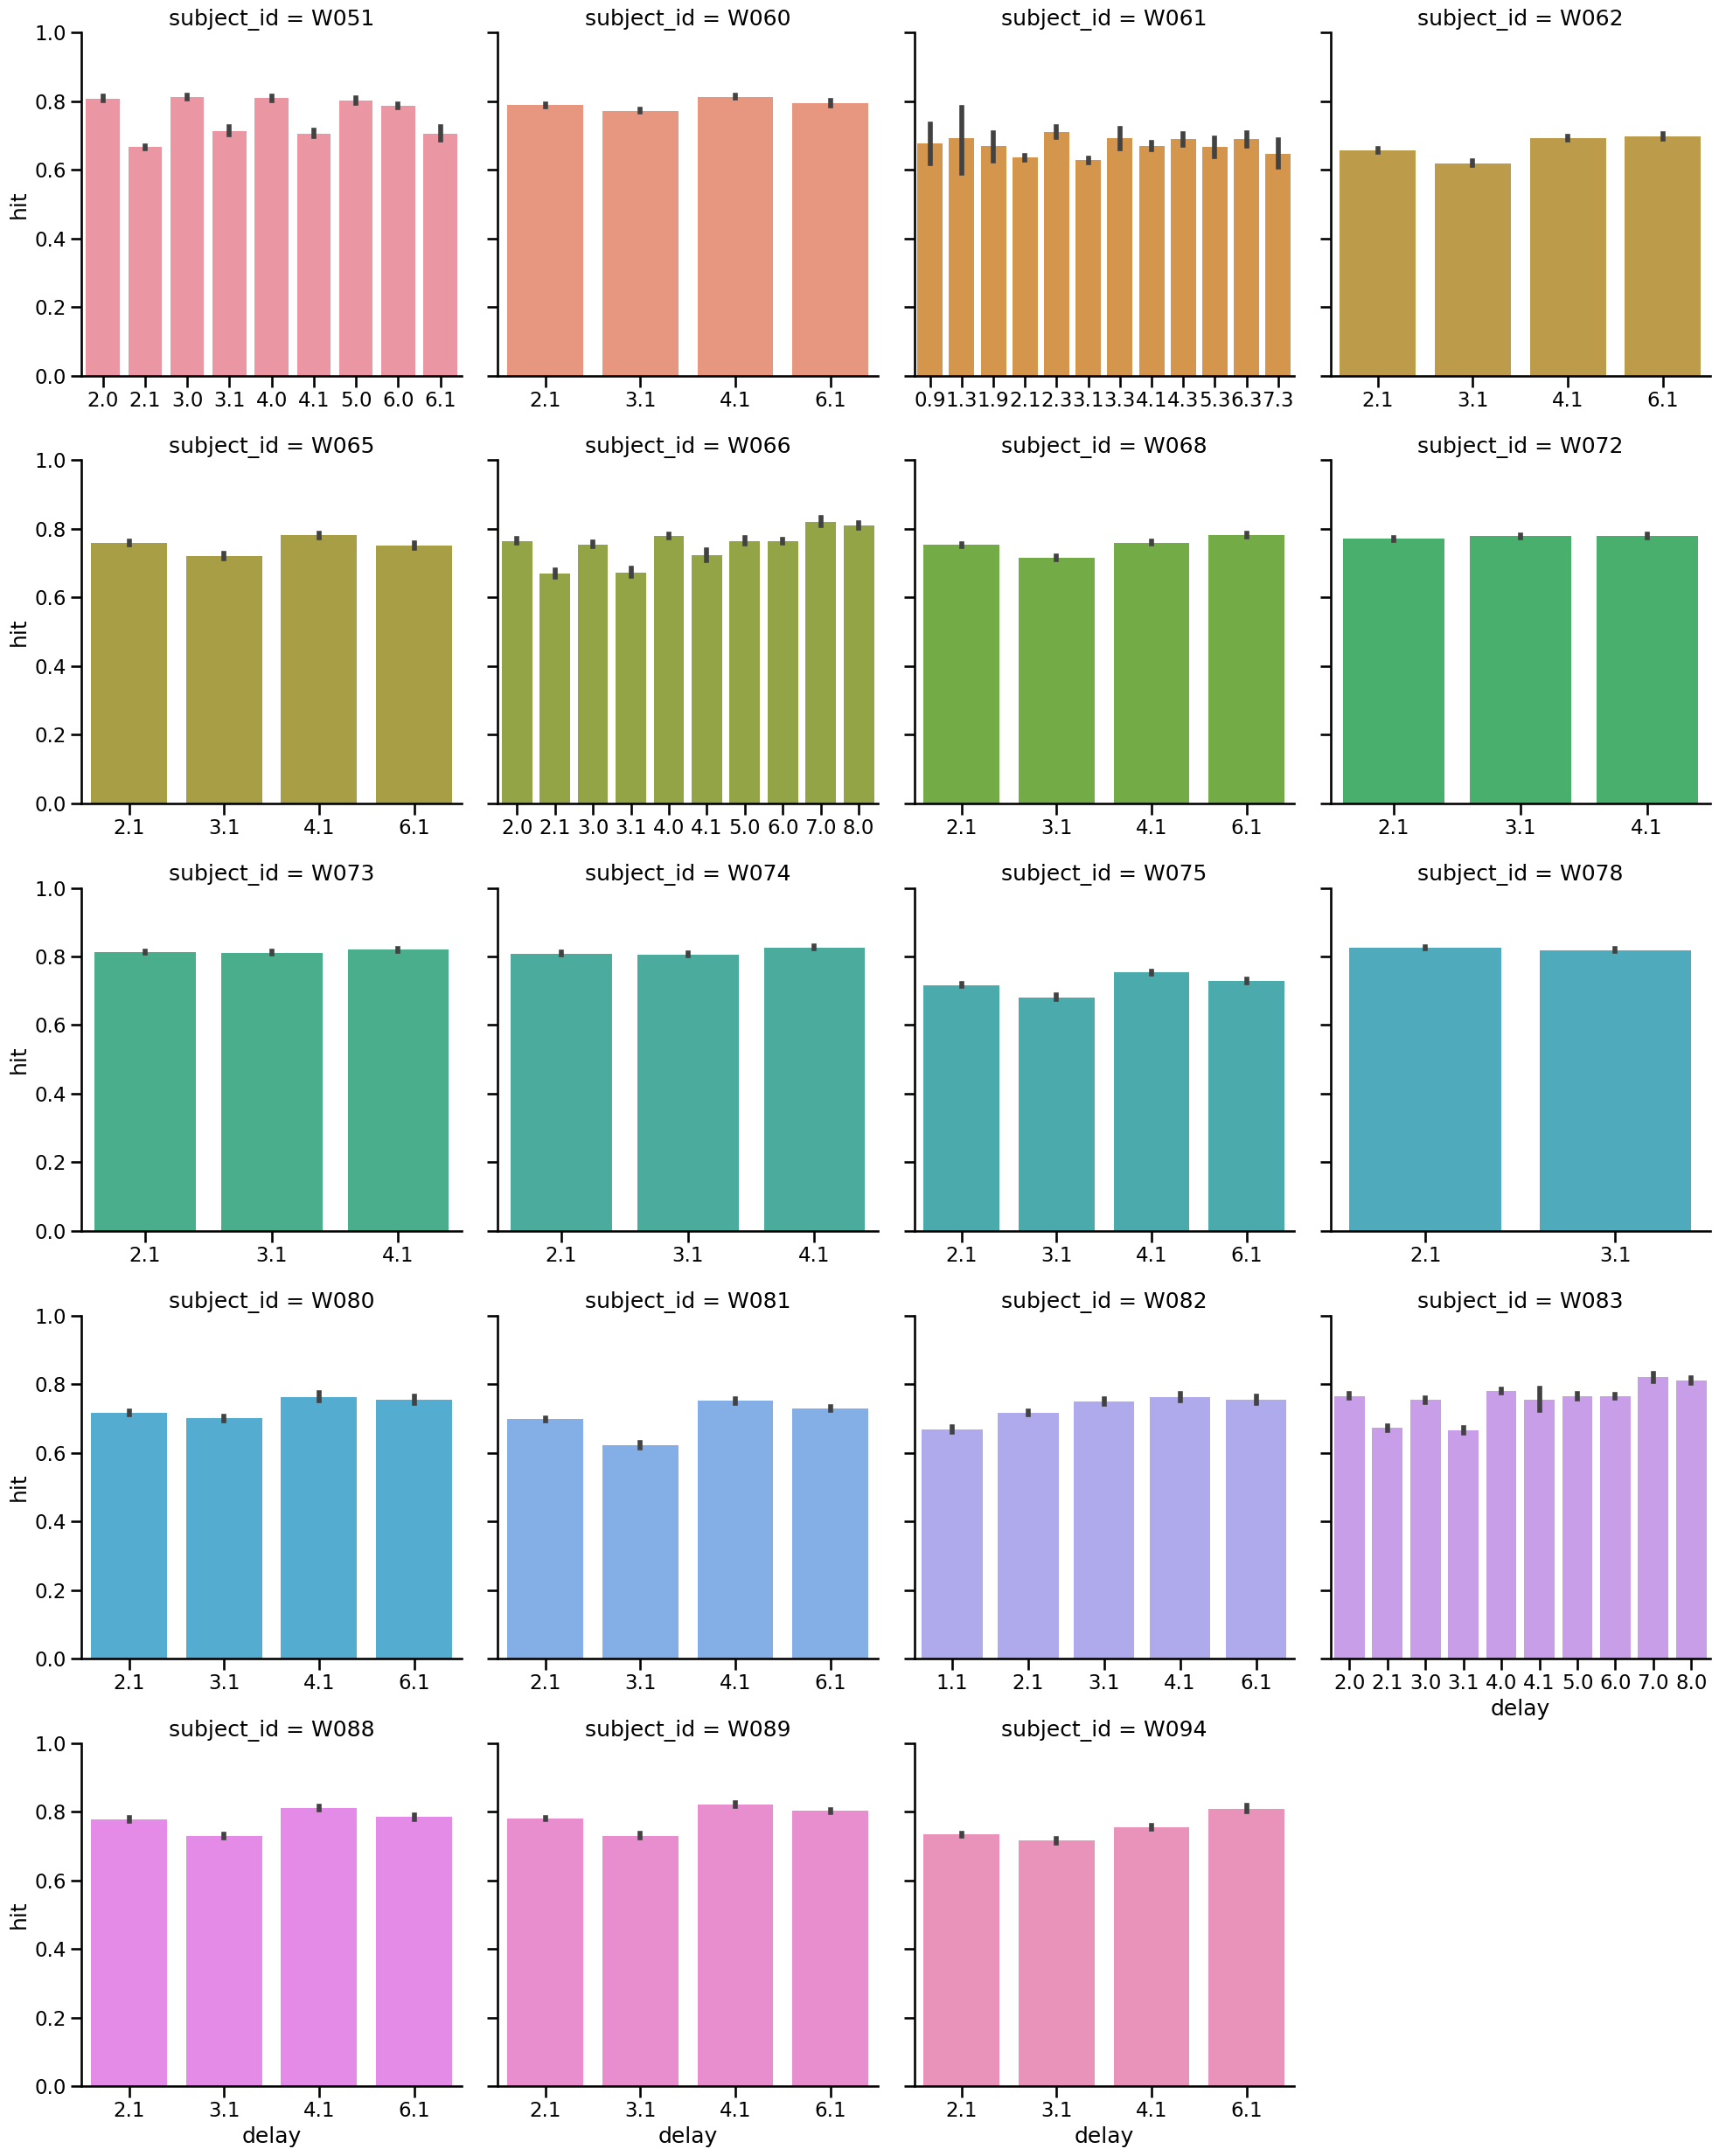

In [69]:
g = sns.catplot(
    x="delay",
    y="hit",
    col="subject_id",
    col_wrap=4,
    hue="subject_id",
    data=RAT_DF.query("training_stage >=  3"),
    kind="bar",
    dodge=False,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0, 1))

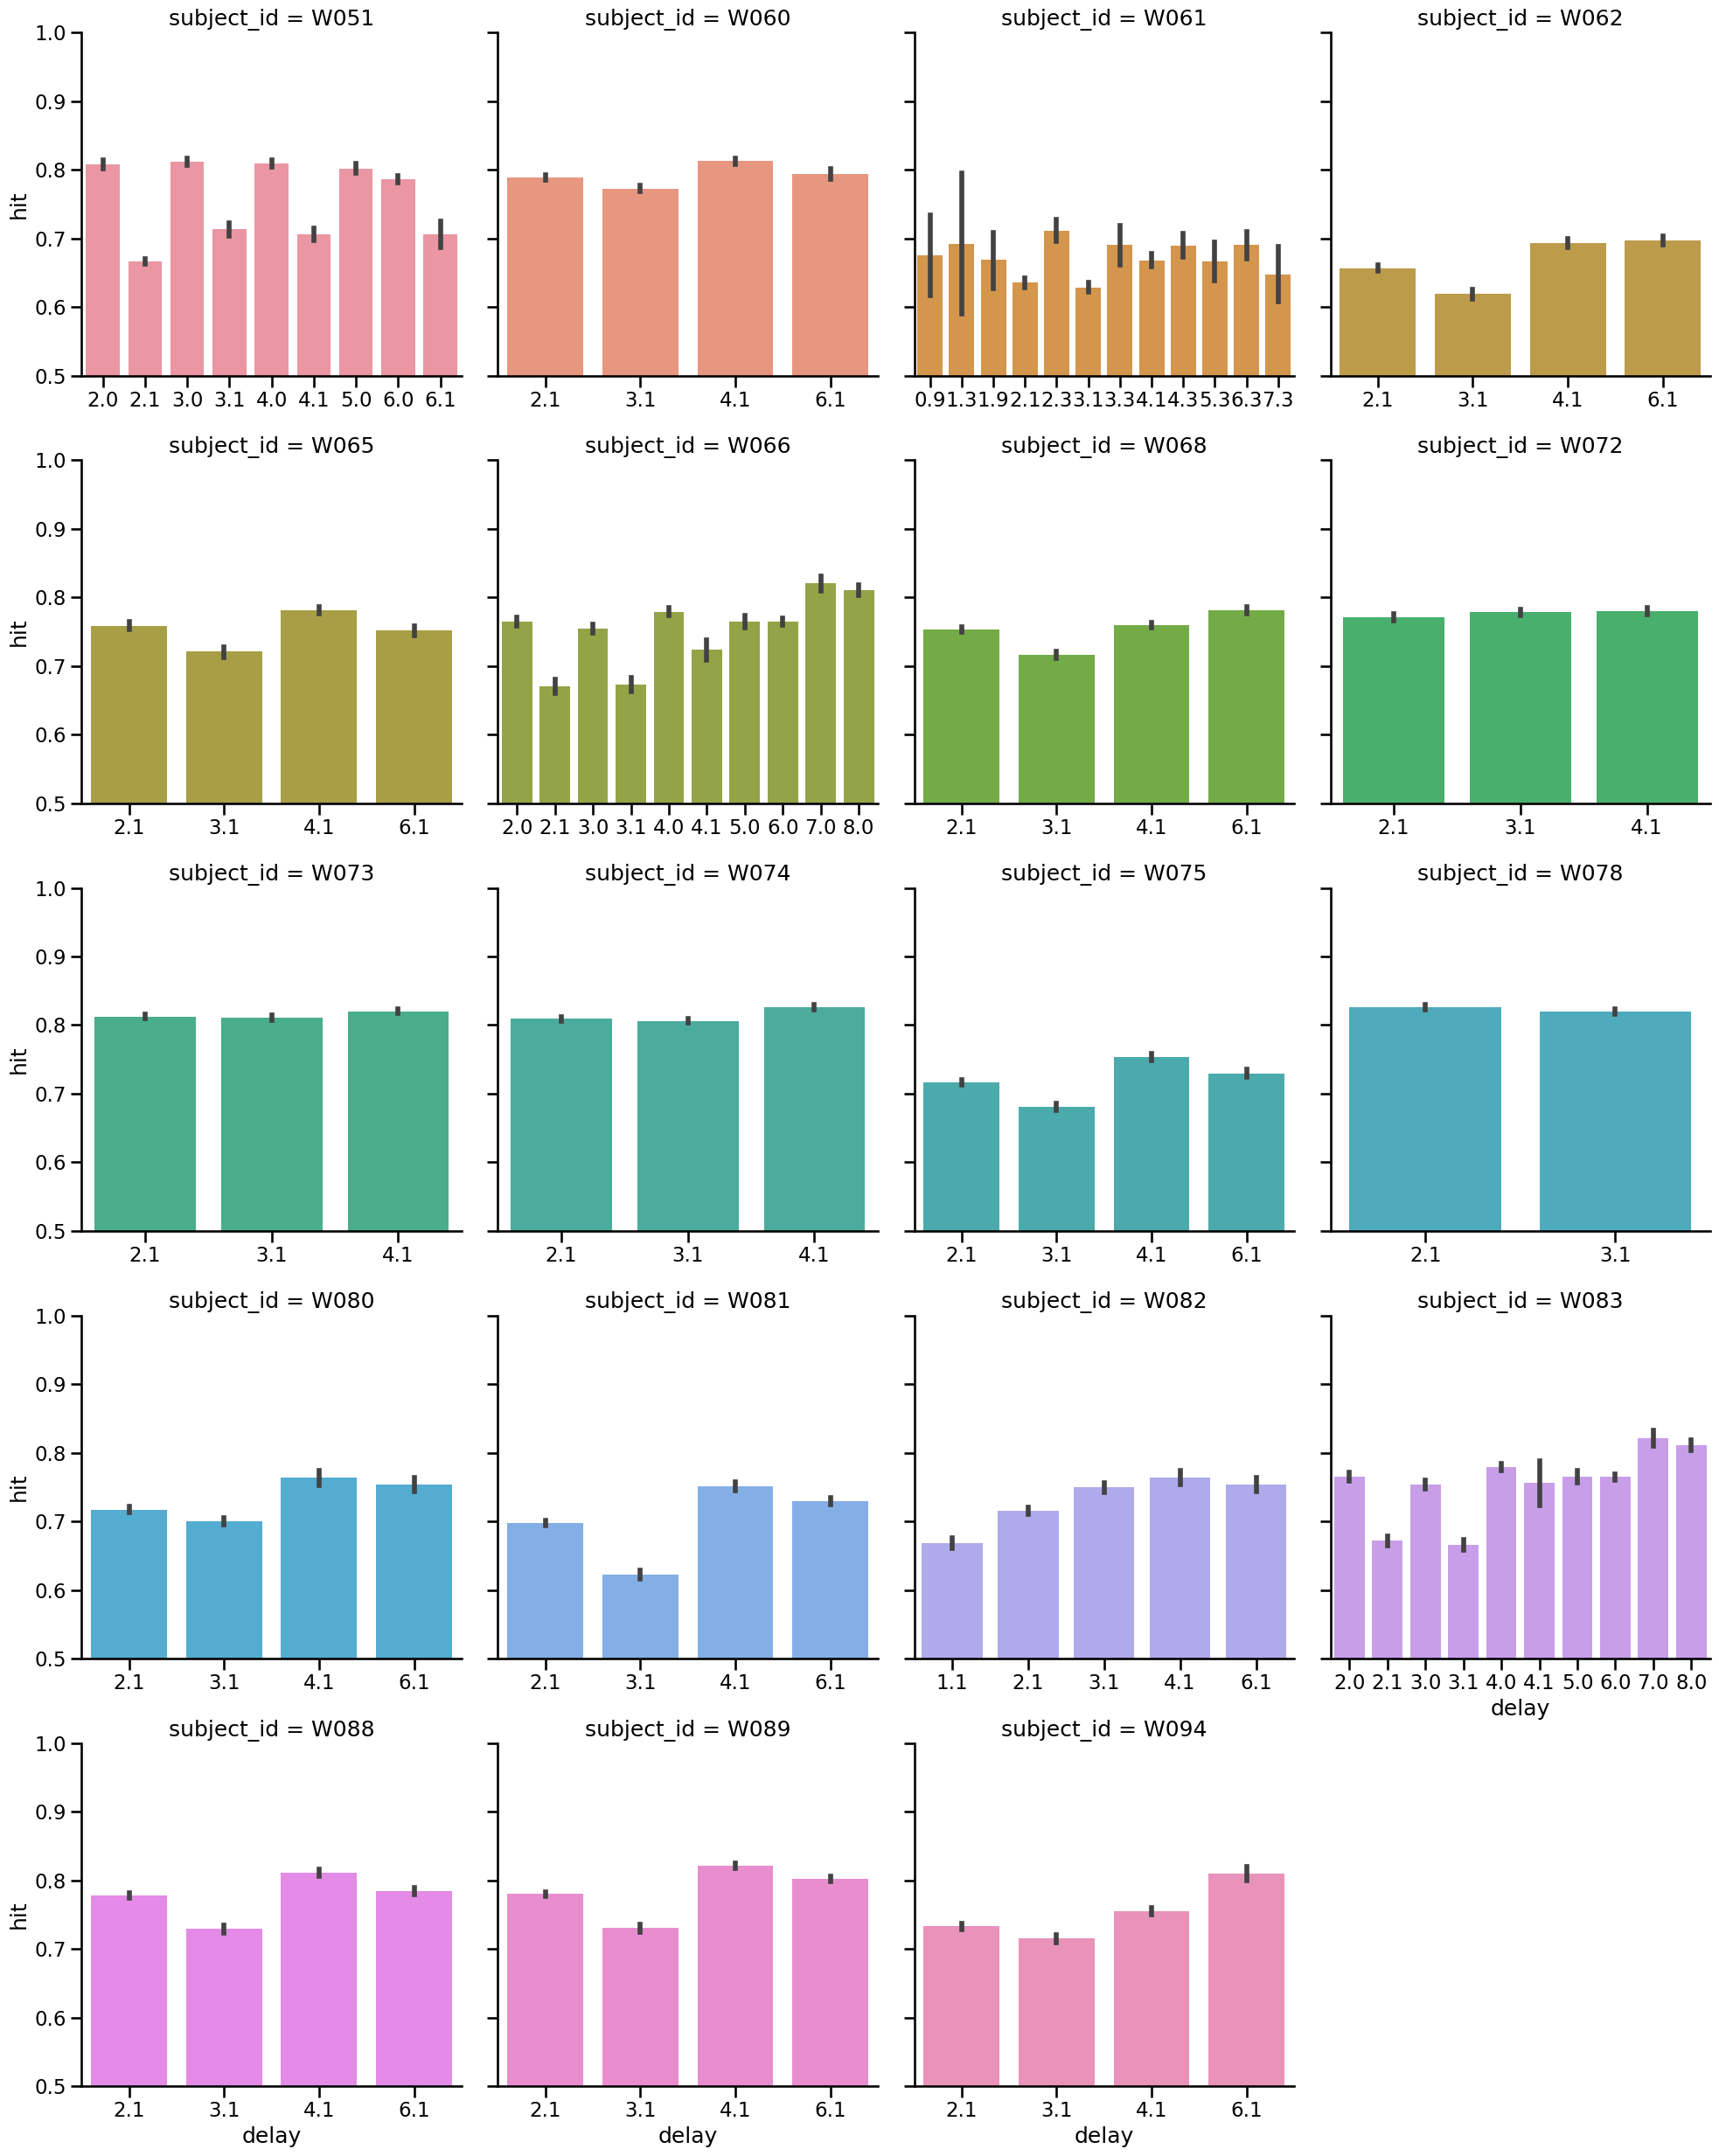

In [68]:
g = sns.catplot(
    x="delay",
    y="hit",
    col="subject_id",
    col_wrap=4,
    hue="subject_id",
    data=RAT_DF.query("training_stage >=  3"),
    kind="bar",
    dodge=False,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0.5, 1))

Performance on delays is much lower in stage 3 than 4. This makes sense because it is when the sound rule is introduced.

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


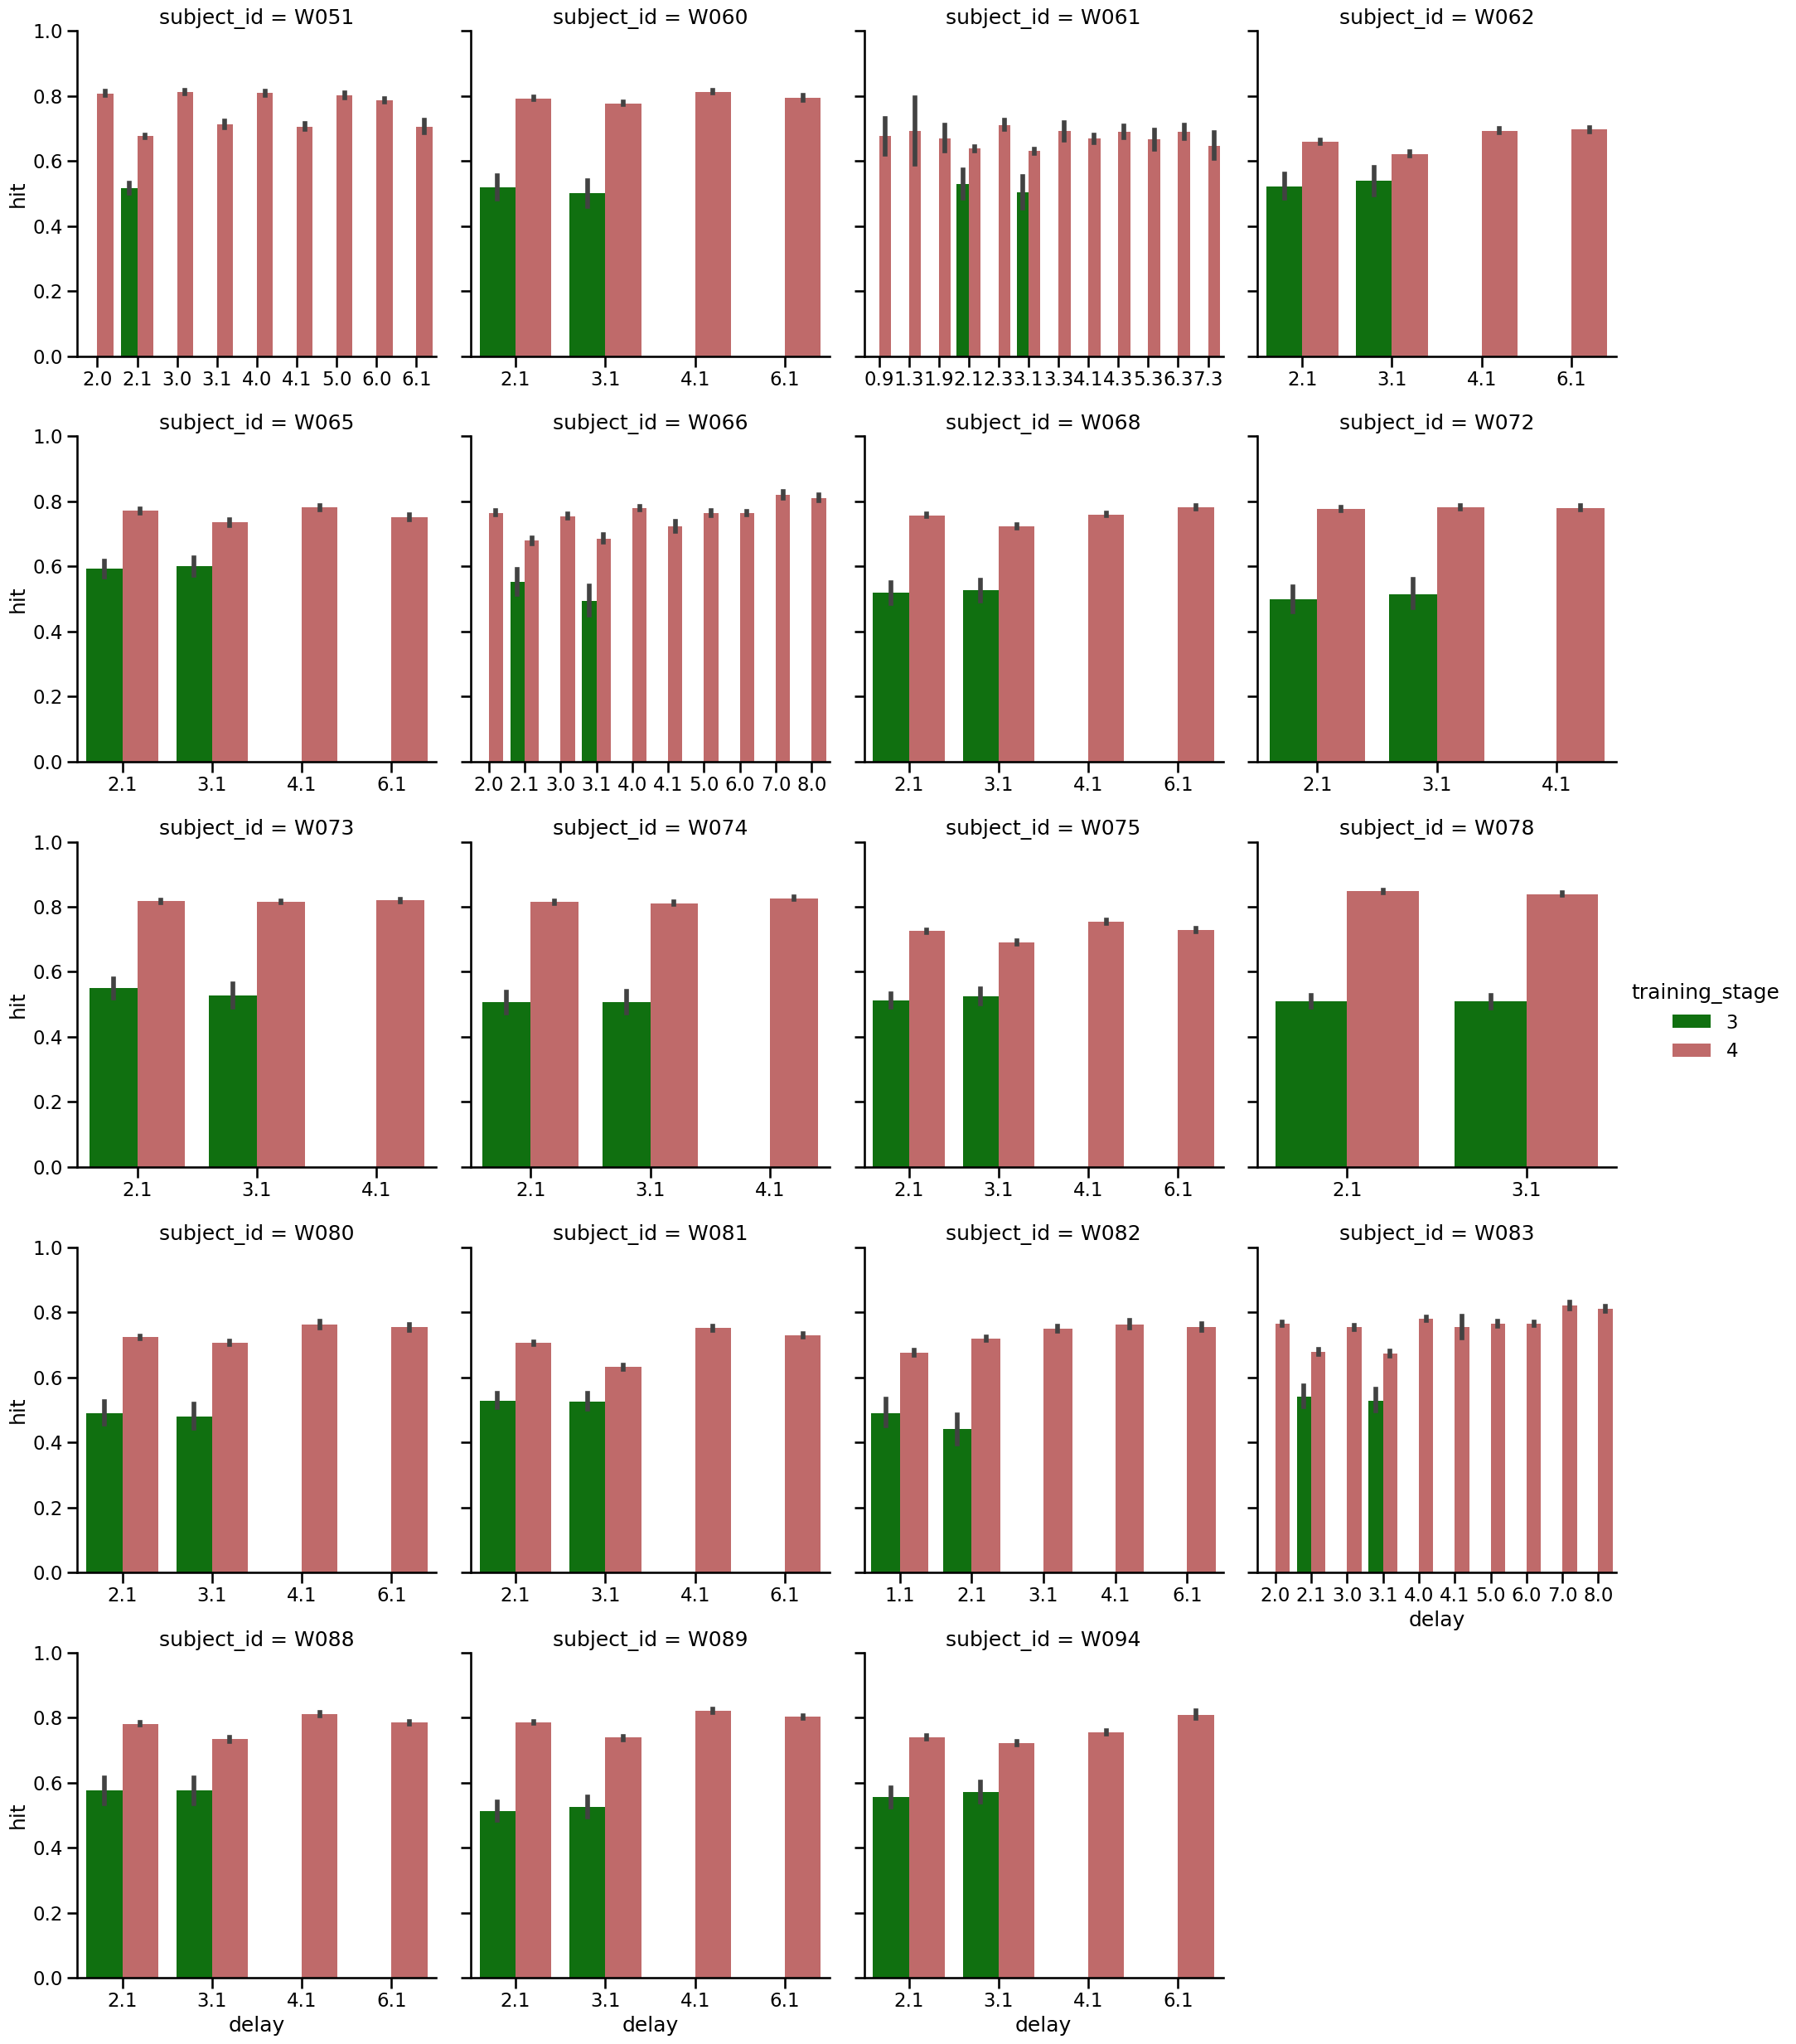

In [81]:
g = sns.catplot(
    x="delay",
    y="hit",
    col="subject_id",
    col_wrap=4,
    hue="training_stage",
    data=RAT_DF.query("training_stage >=  3"),
    kind="bar",
    palette=["green", "indianred"],
    dodge=True,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0, 1))

The more delays an animal experiences, the longer it takes them to train and the worse their final performance is.

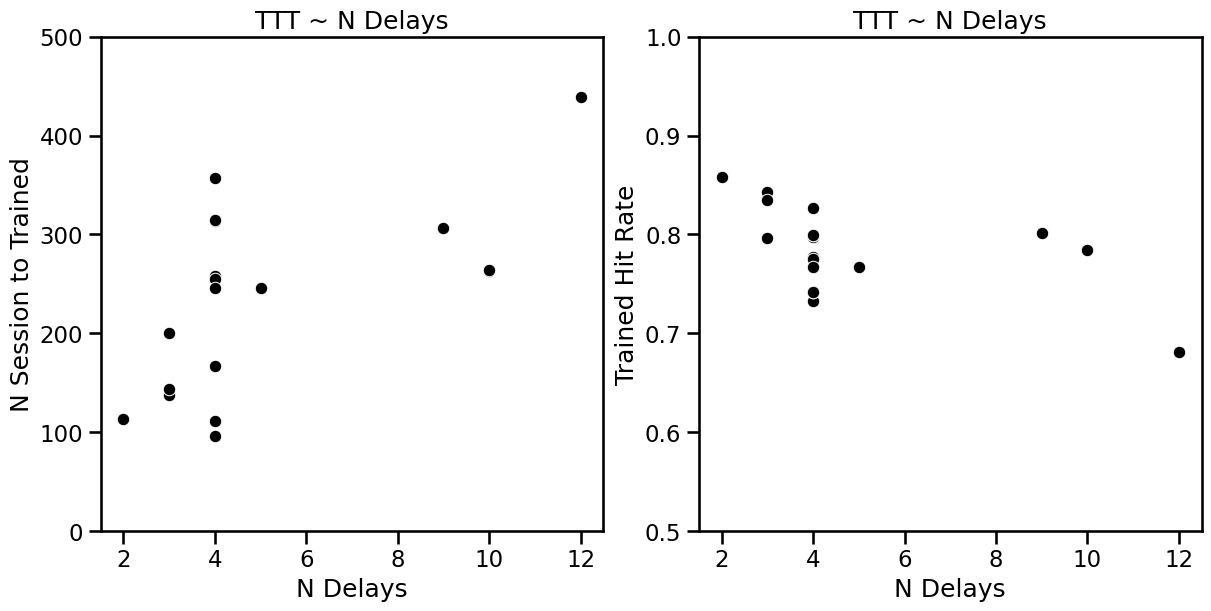

In [103]:
train_threshold_df['n_delays'] = train_threshold_df["subject_id"].map(
    RAT_DF.query('training_stage >= 3').groupby("subject_id").delay.nunique()
)

fig, ax = plt.subplots(1,2, figsize=(12, 6), constrained_layout=True)
sns.scatterplot(
    data=train_threshold_df, y="max_cross_sess", x="n_delays", color="k", ax=ax[0]
)

_ = ax[0].set(
    ylim=(0, 500),
    ylabel="N Session to Trained",
    xlabel="N Delays",
    title="TTT ~ N Delays",
)

sns.scatterplot(
    data=train_threshold_df, y="post_train_hit", x="n_delays", color="k", ax=ax[1]
)

_ = ax[1].set(
    ylim=(0.5, 1),
    ylabel="Trained Hit Rate",
    xlabel="N Delays",
    title="TTT ~ N Delays",
)

## Sound Pairs

[ ] make sa,sb pair column

[ ] plot performance by pair over sessions for each animal

[ ] make sa/sb plot for each 

[ ] make sa/sb plot for each animal, stage (?)


In [65]:
W080_df.groupby(["s_a", "s_b"]).size().reset_index().rename(columns={0: "count"})

s_a   s_b  count
0   60.0  68.0  14436
1   68.0  60.0  10247
2   68.0  76.0   8863
3   68.5  76.0    345
4   71.5  76.0    347
5   74.5  76.0    363
6   76.0  68.0  10176
7   76.0  84.0   8952
8   77.5  76.0    396
9   80.5  76.0    383
10  83.5  76.0    351
11  84.0  76.0  10146
12  84.0  92.0   8736
13  92.0  84.0  15750